In [1]:
print("test")

test


# Analysis

In [2]:
import pandas as pd
# from LabData.DataLoaders.GutMBLoader import GutMBLoader
# from LabData.DataLoaders.SubjectLoader import SubjectLoader
# from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
# from LabData.DataAnalyses.TenK_Trajectories.utils import get_diet_logging_around_stage
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
import math
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import re

In [3]:
home_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/'
SPECIES = 'segal_species' # 'segal_species' or 'mpa_species'
color1 = "#66C2A5"
single_style = "nature_single.mplstyle"
double_style = "nature_double.mplstyle"
third_style = "nature_third.mplstyle"
plt.rcParams["figure.dpi"] = 150
plt.style.use(single_style)

In [4]:
def read_results(df):
    output = []
    for col in df.columns:
        output.append(df[col])
    return tuple(output)

In [5]:
species = '' if SPECIES == 'segal_species' else '_mpa'

diet_mb = pd.read_pickle(home_path + f"data/{SPECIES}/diet_mb.pkl")
with open(home_path + f'data/{SPECIES}/my_lists.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
base_features, all_features, targets = loaded_lists
with open(home_path + f'data/{SPECIES}/scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)
diet_mb

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,...,fBin__94|gBin__449|sBin__656,fBin__95|gBin__450|sBin__659,fBin__96|gBin__457|sBin__669,fBin__97|gBin__462|sBin__676,fBin__97|gBin__462|sBin__678,fBin__99|gBin__469|sBin__687,Richness,Shannon_diversity,GMWI2_score,modified_HACK_top17_score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016416,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.00000,189,3.75,0.930216,96.28125
10K_1001201093,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013895,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.00000,150,3.34,0.881661,157.28125
10K_1002254441,0.0,0.0,0.0,0.0,0.0,0.081238,0.0,0.000000,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-2.383721,-4.00000,250,4.25,0.820586,205.53125
10K_1003113258,0.0,0.0,0.0,0.0,0.0,0.002048,0.0,0.008929,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-3.806766,-4.00000,262,4.29,1.025713,147.28125
10K_1007330152,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-1.937423,-2.98186,194,3.75,1.202788,92.56250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,0.0,0.0,0.0,0.0,0.0,0.002401,0.0,0.000000,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-3.832439,-3.78628,257,4.01,0.783450,153.59375
10K_9998420917,0.0,0.0,0.0,0.0,0.0,0.019995,0.0,0.018783,0.000000,0.0,...,-4.0,-4.0,-4.0,-2.564519,-2.439687,-4.00000,264,4.25,0.781873,130.71875
10K_9998635752,0.0,0.0,0.0,0.0,0.0,0.001607,0.0,0.011305,0.000000,0.0,...,-4.0,-4.0,-4.0,-4.000000,-2.996193,-4.00000,183,3.28,1.176277,137.21875


In [6]:
targets_reformatted = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in targets]

In [7]:
len(targets)

724

Test for intervention model

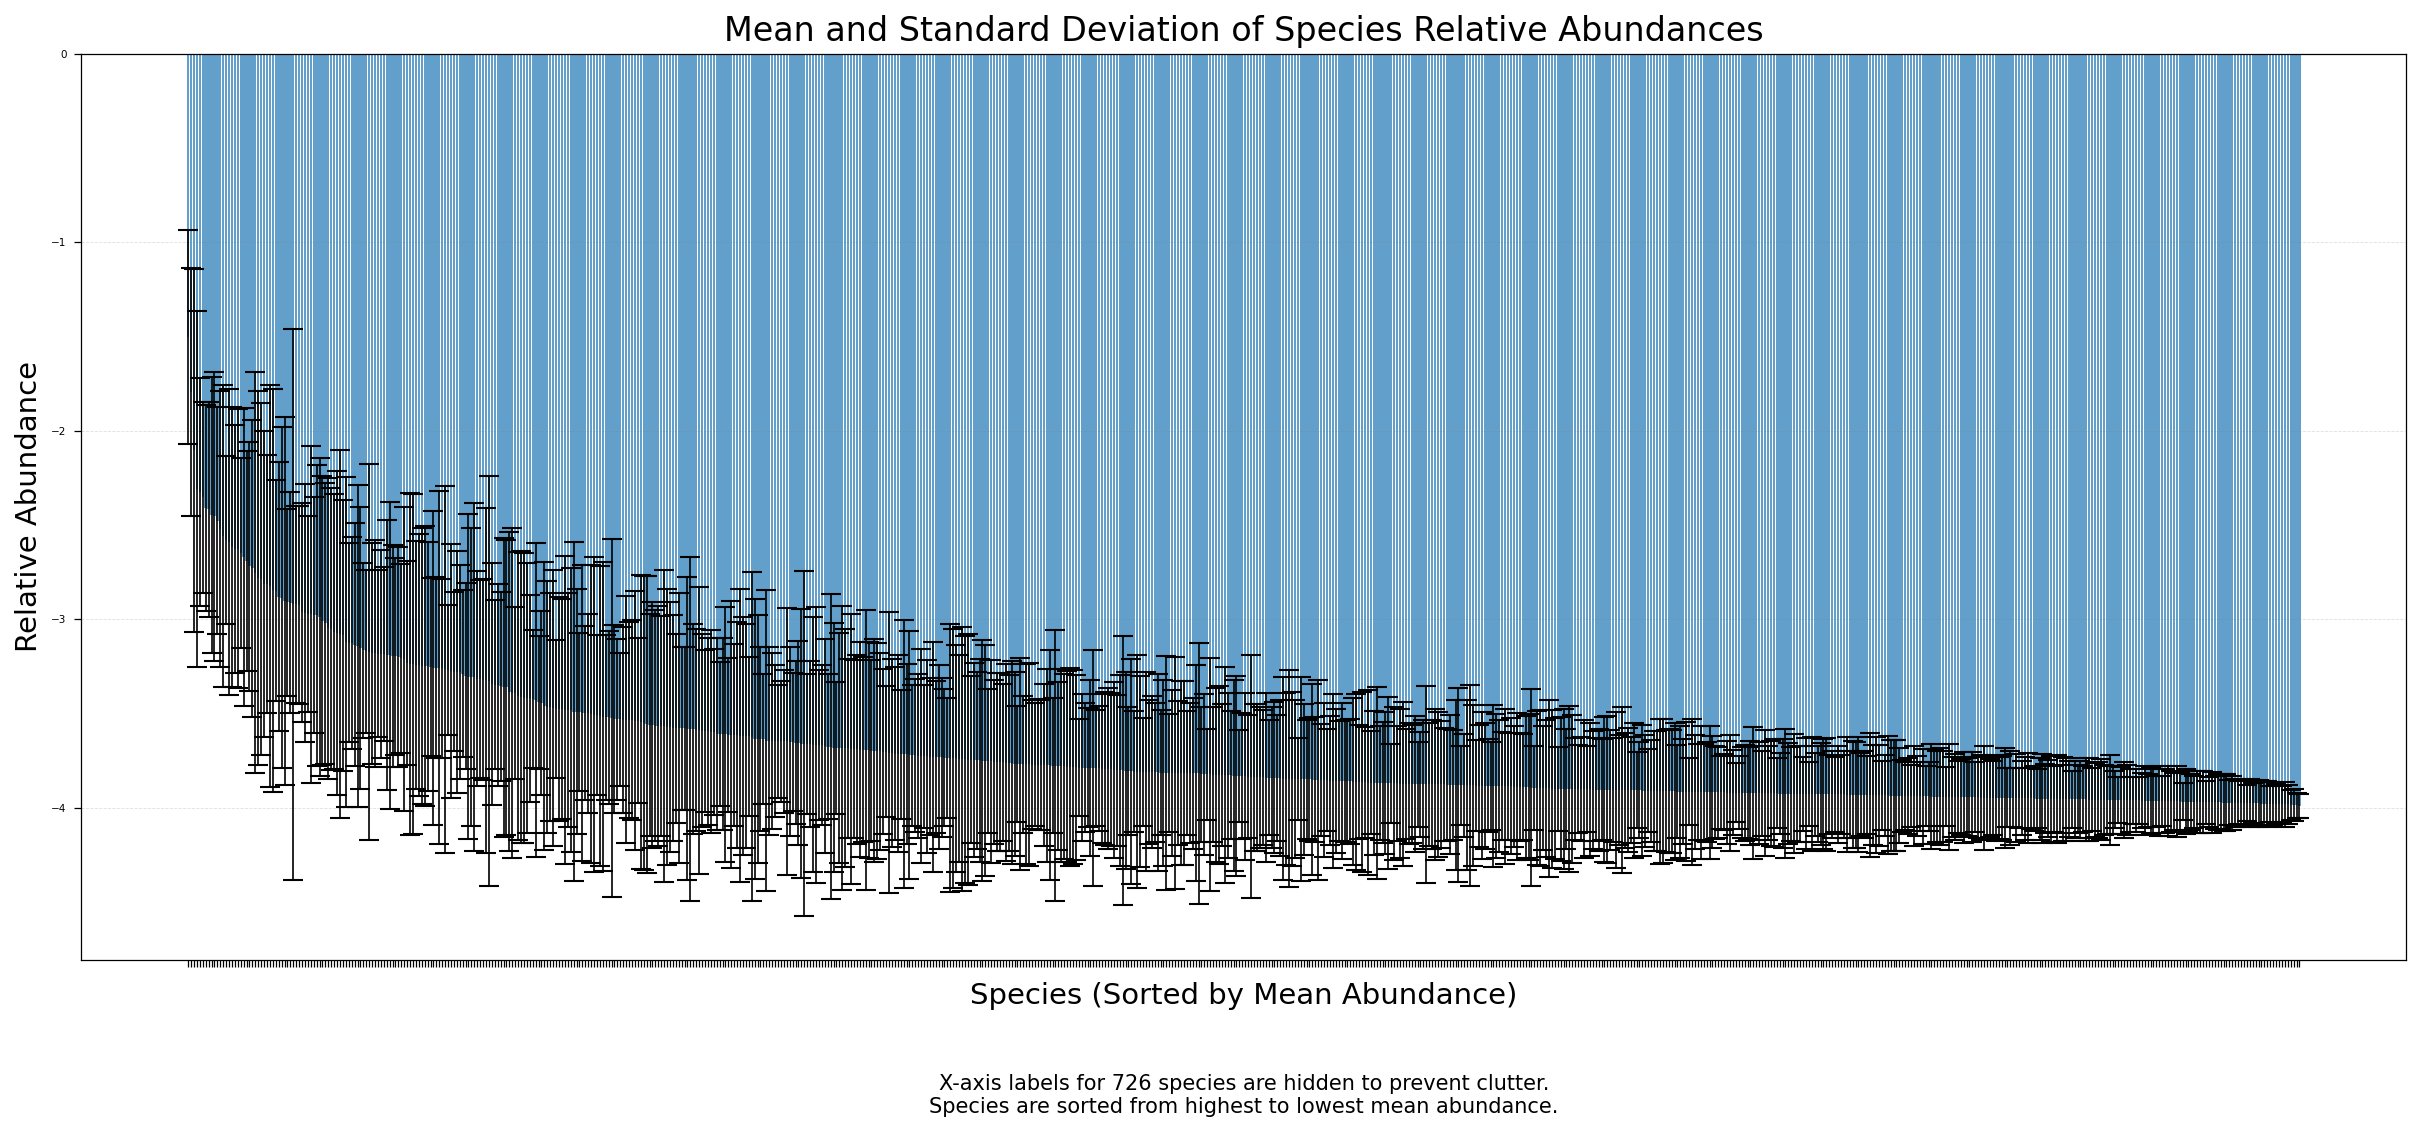

In [8]:
def visualize_species_abundance(df):
    """
    Calculates and visualizes the mean and standard deviation of species abundances,
    sorted by mean abundance.

    Args:
        df (pd.DataFrame): A DataFrame where each column is a species and each
                           row is a sample. The values should be relative abundances.
    """
    # --- 1. Calculate Mean and Standard Deviation ---
    means = df.mean()
    stds = df.std()

    # --- 2. Sort data by mean abundance ---
    # Combine stats into a single DataFrame to ensure proper alignment when sorting.
    stats_df = pd.DataFrame({'means': means, 'stds': stds})
    # Sort the DataFrame by the 'means' column in descending order.
    stats_df_sorted = stats_df.sort_values(by='means', ascending=False)


    # --- 3. Create the Visualization ---
    # Set up the figure and axes for the plot.
    # We make it wide to accommodate the large number of species.
    fig, ax = plt.subplots(figsize=(20, 8))

    # Create an array for the x-axis positions of the bars.
    x_pos = np.arange(len(df.columns))

    # --- 4. Plot the Bar Chart with Error Bars using Sorted Data ---
    # The bar chart will show the mean abundance for each species.
    # The 'yerr' argument adds the standard deviation as error bars on top of each bar.
    ax.bar(x_pos, stats_df_sorted['means'], yerr=stats_df_sorted['stds'], align='center', alpha=0.7, ecolor='black', capsize=5)

    # --- 5. Customize the Plot for Readability ---
    ax.set_ylabel('Relative Abundance', fontsize=14)
    ax.set_xlabel('Species (Sorted by Mean Abundance)', fontsize=14)
    ax.set_title('Mean and Standard Deviation of Species Relative Abundances', fontsize=16)
    
    # Since there are 726 species, the x-axis labels would be unreadable.
    # We will disable them by default. The species are now sorted from most
    # to least abundant.
    ax.set_xticks(x_pos)
    ax.set_xticklabels([]) # Hide labels to prevent clutter
    # If you were plotting a smaller number of species (e.g., < 30), you could use:
    # ax.set_xticklabels(stats_df_sorted.index, rotation=90)

    # Add a grid for easier reading of values
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    
    # Add a note about the hidden labels
    plt.text(0.5, -0.15, 'X-axis labels for 726 species are hidden to prevent clutter.\nSpecies are sorted from highest to lowest mean abundance.', 
             ha='center', va='center', transform=ax.transAxes, fontsize=10)


    # Adjust layout to make sure everything fits
    

    # --- 6. Show the Plot ---
    plt.show()


visualize_species_abundance(diet_mb[targets])

In [9]:
def standardize_panel(ax, inner_size=(2.2, 1.6)):
    """
    Make the Axes 'ax' have a fixed inner size (spines rectangle) in inches,
    while letting the figure expand to fit tick labels, axis labels, and the Axes legend.
    """
    fig = ax.figure
    fig.canvas.draw()  # ensure text extents exist
    dpi = fig.dpi
    renderer = fig.canvas.get_renderer()

    # Axes bbox = the inner data rectangle (the "square" you want identical)
    ax_box   = ax.bbox  # in display pixels
    # Tight bbox for THIS axes = ax_box + its decorations (ticks, labels, legend)
    ax_tight = ax.get_tightbbox(renderer=renderer)  # in display pixels

    # Extra space needed around the inner box, in inches
    left_in   = max(0.0, (ax_box.x0 - ax_tight.x0) / dpi)
    right_in  = max(0.0, (ax_tight.x1 - ax_box.x1) / dpi)
    bottom_in = max(0.0, (ax_box.y0 - ax_tight.y0) / dpi)
    top_in    = max(0.0, (ax_tight.y1 - ax_box.y1) / dpi)

    ax_w_in, ax_h_in = inner_size

    # New figure size in inches
    fig_w = left_in + ax_w_in + right_in
    fig_h = bottom_in + ax_h_in + top_in
    if fig_w <= 0 or fig_h <= 0:
        raise ValueError(f"Computed non-positive figure size: {(fig_w, fig_h)}")

    # Resize figure and position the axes so its inner box is exactly inner_size
    fig.set_size_inches(fig_w, fig_h, forward=True)
    ax.set_position([
        left_in / fig_w,
        bottom_in / fig_h,
        ax_w_in / fig_w,
        ax_h_in / fig_h
    ])

    fig.canvas.draw()
    return fig, ax


## Diversity Targets

### Age and Gender

In [10]:
# def train_test(df, features, target_list, model):
#     all_scores = []
#     all_p_values=[]
#     all_coefs = []
#     all_feat_names = []
#     for target in target_list:
#         kf = KFold(n_splits=5, shuffle=False, random_state=1)
#         preds = []
#         targets = []
#         for train_index, test_index in kf.split(df):
#             train = df.iloc[train_index]
#             test = df.iloc[test_index]

#             if model == "ridge":
#                 model = linear_model.RidgeCV(alphas=(0.01, 0.1, 0.5, 1, 10, 100))
#             elif model == "lgbm":
#                 model = lgb.LGBMRegressor(max_depth=4, n_estimators=2000, subsample=0.5, subsample_freq=1, colsample_bytree=1, learning_rate=0.001, n_jobs=8, random_state=1)
#             model.fit(train[features], train[target])
#             predictions = model.predict(test[features])
#             # score = r2_score(test[target], predictions)
#             preds.extend(predictions)
#             targets.extend(test[target])
#             # print(model.alpha_)

#         score = stats.pearsonr(preds, targets)
#         all_scores.append(score[0])
#         all_p_values.append(score[1])
#         if model == "linear":
#             all_coefs.append(model.coef_)
#             all_feat_names.append(model.feature_names_in_)
#         elif model == "lgbm":
#             all_coefs.append(model.feature_importances_)
#             all_feat_names.append(model.feature_name_)
#     return all_scores, all_p_values, all_coefs, all_feat_names

In [11]:
diversity_targets = ['Richness', 'Shannon_diversity']
# ridge_base_scores_div, ridge_base_pvalues_div, ridge_base_coefs_div, ridge_base_fnames_div = train_test(diet_mb, base_features, diversity_targets, "ridge")
ridge_base_scores_div, ridge_base_pvalues_div, ridge_base_coefs_div, ridge_base_preds_div, ridge_base_targets_div = read_results(pd.read_pickle(home_path + f"/data/regression/{SPECIES}/output_base_ridge_div.pkl"))
ridge_base_scores_div

0    0.029014
1    0.087934
Name: 0, dtype: float64

In [12]:
# lgbm_base_scores_div, lgbm_base_pvalues_div, lgbm_base_coefs_div, lgbm_base_fnames_div = train_test(diet_mb, base_features, diversity_targets, "lgbm")
lgbm_base_scores_div, lgbm_base_pvalues_div, lgbm_base_coefs_div, lgbm_base_preds_div, lgbm_base_targets_div = read_results(pd.read_pickle(home_path + f"/data/regression/{SPECIES}/output_base_LGBM_div.pkl"))
lgbm_base_scores_div

0    0.049235
1    0.082398
Name: 0, dtype: float64

In [13]:
# # Save base models results

# ridge_base_res_div = pd.concat([pd.Series(ridge_base_scores_div), pd.Series(ridge_base_pvalues_div), pd.Series(ridge_base_coefs_div), pd.Series(ridge_base_fnames_div)], axis=1)
# ridge_base_res_div.to_pickle(home_path + f"/data/regression/{SPECIES}/ridge_base_div.pkl")

# lgbm_base_res_div = pd.concat([pd.Series(lgbm_base_scores_div), pd.Series(lgbm_base_pvalues_div), pd.Series(lgbm_base_coefs_div), pd.Series(lgbm_base_fnames_div)], axis=1)
# lgbm_base_res_div.to_pickle(home_path +f"data/regression/{SPECIES}/lgbm_base_div.pkl")

### Diet

In [14]:
lgbm_div_scores, lgbm_div_pvalues, lgbm_div_coefs, lgbm_div_preds, lgbm_div_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_div.pkl"))
print(lgbm_div_scores)
print(lgbm_div_pvalues)
print(lgbm_div_coefs)

0    0.240181
1    0.215410
Name: 0, dtype: float64
0    1.139005e-106
1     1.106958e-85
Name: 1, dtype: float64
0    [1, 1, 5, 0, 7, 47, 1, 153, 19, 0, 2, 9, 4, 5,...
1    [0, 0, 12, 0, 1, 49, 24, 109, 13, 0, 1, 2, 1, ...
Name: 2, dtype: object


In [15]:
lgbm_div_scores_test, lgbm_div_pvalues_test, lgbm_div_coefs_test, lgbm_div_preds_test, lgbm_div_targets_test = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/predictions_LGBM_div_baseline.pkl"))
print(lgbm_div_scores_test)
print(lgbm_div_pvalues_test)
print(lgbm_div_coefs_test)

0    0.250980
1    0.242413
Name: 0, dtype: float64
0    1.451718e-29
1    1.236802e-27
Name: 1, dtype: float64
0    [3, 0, 7, 0, 3, 46, 5, 138, 12, 1, 3, 7, 0, 3,...
1    [0, 0, 14, 0, 1, 75, 29, 121, 8, 0, 2, 3, 1, 6...
Name: 2, dtype: object


In [16]:
# def remove_problematic_features(coefs, fnames):
#     features_to_drop = ['Beans_black_eyed_peas', 'Mille_feuille', 'cereal_type__Cornflakes_with_sugar__cookies__pillows__etc__', 'never_eat__Sugar_or_foods___beverages_that_contain_sugar']
#     indexes = []
#     for item in features_to_drop:
#         index = fnames.index(item)
#         indexes.append(index)
#     return indexes

# remove_problematic_features(lgbm_div_coefs, lgbm_div_fnames[0])

In [17]:
coefs_richness = pd.Series(lgbm_div_coefs[0])
fnames_richness = pd.Series(all_features)
print(coefs_richness.sort_values())
print(fnames_richness.iloc[coefs_richness.sort_values()[-5:].index])

349      0
321      0
320      0
101      0
314      0
      ... 
606    350
556    354
638    358
676    371
169    394
Length: 700, dtype: int32
606                Caffeine
556                    Wine
638    pct_alcohol_calories
676                  Fruits
169                   Dates
dtype: object


In [18]:
ridge_div_scores, ridge_div_pvalues, ridge_div_coefs, ridge_div_preds, ridge_div_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_ridge_div.pkl"))
ridge_div_scores

0    0.173195
1    0.150259
Name: 0, dtype: float64

[0.30398468464189965, -0.22142705876397467, -0.8565842409781842, -0.14830462940318517, 0.008970908170269631, 0.3006263217307132, 0.12926021912916347, -0.1288013938905388, 0.34073517694193745, -0.1106663632123365, -0.3390981460795418, -0.5502691659693923, 0.02475718395883339, 0.15835332068179223, 0.08400415841112435, -0.4560899837800647, -0.9868169849225998, -0.37002105541153746, -0.5961120599589246, 0.19400130942543928, 0.14199888335316924, 0.09125494155089872, 0.47803331331909216, -0.04018988793793132, 0.14531564006873907, 0.13265725058390287, -0.6152985832025498, -0.008787350382168678, 0.28800468073353347, 0.018545332940937173, -0.6748074506835235, 0.7413226435691365, 0.2136796834223752, 0.06019957220224742, -0.23965718167190242, -0.01467809318642848, -0.3519005154059068, -0.7260527698319795, -0.0786630117235197, 0.2066051407919393, 0.019843995797982558, -0.14904751703720587, 0.13158325625982834, 0.012484993339654915, -0.9678741508972208, -0.12130486775923537, 0.2044212210240079, -0.

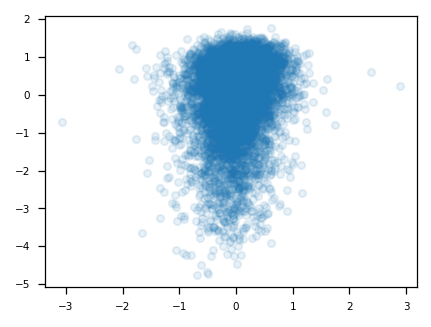

In [19]:
plt.scatter(ridge_div_preds[1], ridge_div_targets[1], alpha=0.1)
print(ridge_div_preds[0])
print(ridge_div_targets[0])
plt.show()

[0.08749170072412973, 0.062059834853718, -0.20969218173938206, 0.040680654848549436, 0.009188857451718914, 0.06559318553775274, 0.1163496294361453, -0.03314725933184709, 0.2407969210976222, 0.03514012929484937, -0.0749934417371715, -0.1581664712270331, -0.05826237538388608, -0.05833861899462892, 0.067274100636203, -0.07987179687171356, -0.18122866666076135, 0.002160761470382775, -0.10996790712054574, 0.10110825461928073, -0.027001585248372827, 0.10518955593591077, 0.19080070134659086, -0.3197367482564069, 0.11506685251959964, 0.2772945780484689, -0.3361601134109849, -0.02383603015930817, 0.22911845546951112, 0.04853884232863191, -0.09253826507774407, 0.20111986334918427, 0.11147918922204438, -0.06856981067668227, 0.06025146605930198, -0.019721947718964246, -0.1565645309541229, -0.05766925117491735, 0.11116660189244389, -0.07686581095885342, 0.11325177237849961, -0.12204282849144883, 0.22965394799095218, -0.02995190942878896, -0.049035723417041294, 0.09559692478301494, 0.063886957814246

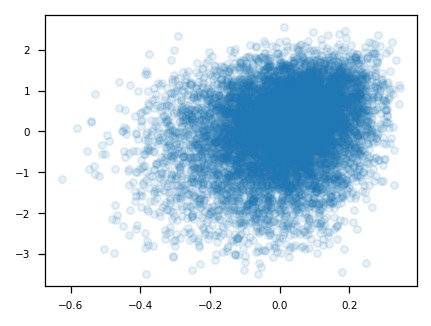

In [20]:
plt.scatter(lgbm_div_preds[0], lgbm_div_targets[0], alpha=0.1)
print(lgbm_div_preds[0])
print(lgbm_div_targets[0])
plt.show()

#### What is a good correlation?
Comparing to permutated data. (Uncomment later)

In [21]:
div_perm_scores = pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_div_perm.pkl")
div_perm_scores

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Richness,-0.004548,0.002623,-0.006180,-0.00271,-0.020125,-0.001202,-0.012272,0.020088,-0.039574,0.010693,...,-0.012112,-0.005179,0.023111,-0.038600,0.015567,-0.012790,0.021568,0.001332,0.003479,0.012874
Shannon_diversity,-0.006819,0.010137,0.000833,-0.01920,0.004590,-0.015225,0.007133,-0.007466,-0.016481,-0.010821,...,-0.007938,0.023048,0.016538,-0.018418,0.044290,-0.005717,-0.017428,-0.004598,-0.001655,0.018402


Max corr permutation: 0.04648394948354974


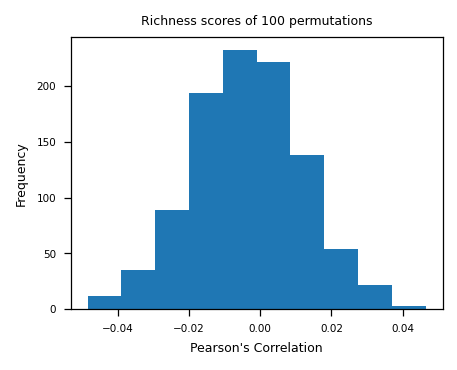

In [22]:
richness_perm_scores = pd.Series(div_perm_scores.iloc[0])
richness_perm_scores.plot.hist()
# plt.axvline(richness_perm_scores.mean(), color="red")
# plt.axvline(richness_perm_scores.median(), color="black")
plt.title("Richness scores of 100 permutations")
plt.xlabel("Pearson's Correlation")
print("Max corr permutation:", max(richness_perm_scores))

Max corr permutation: 0.04476666111082697


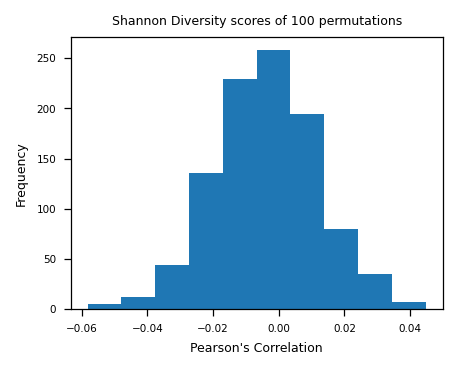

In [23]:
shannon_perm_scores = pd.Series(div_perm_scores.iloc[1])
shannon_perm_scores.plot.hist()
# plt.axvline(shannon_perm_scores.mean(), color="red")
# plt.axvline(shannon_perm_scores.median(), color="black")
plt.title("Shannon Diversity scores of 100 permutations")
plt.xlabel("Pearson's Correlation")
print("Max corr permutation:", max(shannon_perm_scores))

In [24]:
def calc_p_value(perm_scores, true_score):
    bigger_than_true = (perm_scores >= true_score).sum()
    print(bigger_than_true)
    return (bigger_than_true + 1) / (len(perm_scores) + 1)
    

richness_true_score = lgbm_div_scores[0]
shannon_true_score = lgbm_div_scores[1]
richness_pval = calc_p_value(richness_perm_scores, richness_true_score)
shannon_pval = calc_p_value(shannon_perm_scores, shannon_true_score)
# If pval is 0, it means it's smaller than 0.001 since I did 1000 permutations.

0
0


In [25]:
def calc_confidence_interval(scores):
    return scores.quantile(0.025), scores.quantile(0.975)

richness_ci = calc_confidence_interval(richness_perm_scores)
shannon_ci = calc_confidence_interval(shannon_perm_scores)

print("Richness confidence interval:", richness_ci)
print("Shannon diversity confidence interval:", shannon_ci)

Richness confidence interval: (-0.033818060694964285, 0.027421649887270944)
Shannon diversity confidence interval: (-0.03435686745377754, 0.02777036841230377)


                  Ridge  LightGBM
Richness       0.173195  0.240181
Shannon Index  0.150259  0.215410


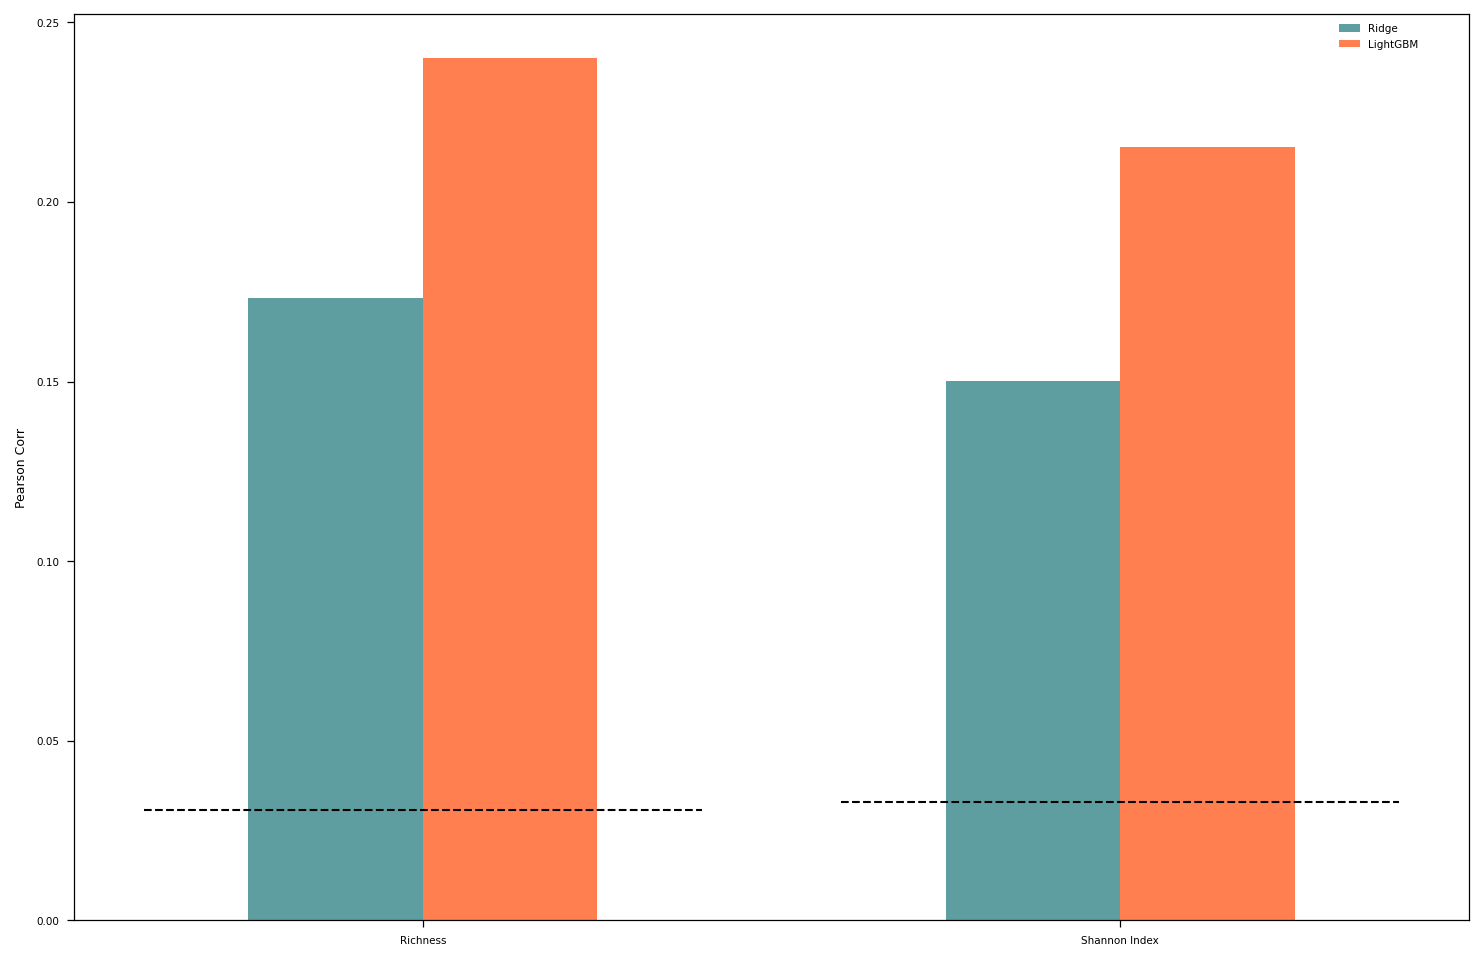

<Figure size 480x360 with 0 Axes>

In [26]:
# Assuming to_plot is already prepared
to_plot = pd.concat([ridge_div_scores, lgbm_div_scores], axis=1)
to_plot.columns = ["Ridge", "LightGBM"]
to_plot.index = ["Richness", "Shannon Index"]
print(to_plot)

# Plot the bar chart
ax = to_plot.plot(kind="bar", legend=True, figsize=(12, 8), color=['cadetblue', 'coral'])
# plt.title("Pearson corr of diversity metrics")
plt.ylabel("Pearson Corr")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.9, 1.0), loc='upper left')

# Calculate bar positions
bar_positions = range(len(to_plot))  # x-positions for the bars (0 for Richness, 1 for Shannon)

# Add separate horizontal lines for each index
percentile_99_richness = np.percentile(richness_perm_scores.values.flatten(), 99)
percentile_99_shannon = np.percentile(shannon_perm_scores.values.flatten(), 99)

# Horizontal line for Richness
ax.plot(
    [bar_positions[0] - 0.4, bar_positions[0] + 0.4],  # x-range covering the Richness bar
    [percentile_99_richness, percentile_99_richness],  # y-values for the horizontal line
    color='black', linestyle='--', linewidth=1, label="99th percentile (Richness)"
)

# Horizontal line for Shannon Index
ax.plot(
    [bar_positions[1] - 0.4, bar_positions[1] + 0.4],  # x-range covering the Shannon Index bar
    [percentile_99_shannon, percentile_99_shannon],  # y-values for the horizontal line
    color='black', linestyle='--', linewidth=1, label="99th percentile (Shannon)"
)


# # Annotate the lines
# plt.text(bar_positions[0], percentile_99_richness + 0.01, f"{percentile_99_richness:.2f}", color='black', fontsize=10, ha='center')
# plt.text(bar_positions[1], percentile_99_shannon + 0.01, f"{percentile_99_shannon:.2f}", color='black', fontsize=10, ha='center')

# Save and show the plot
# plt.savefig(home_path +f"figures/regression/{SPECIES}/diversity_corr_ridge_lgbm_with_percentiles_separate.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()


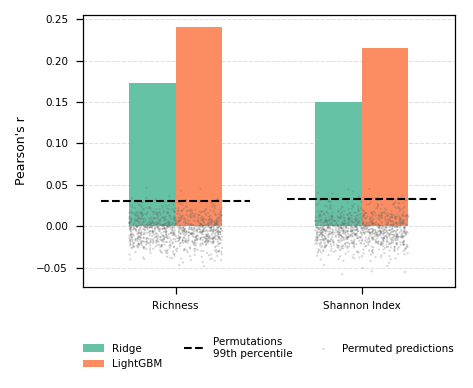

<Figure size 480x360 with 0 Axes>

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1) PREPARE DATA
to_plot = pd.concat([ridge_div_scores, lgbm_div_scores], axis=1)
to_plot.columns = ["Ridge", "LightGBM"]
to_plot.index = ["Richness", "Shannon Index"]

richness_df = pd.DataFrame({
    'score': richness_perm_scores.values.flatten(),
    'target': 'Richness'
})
shannon_df = pd.DataFrame({
    'score': shannon_perm_scores.values.flatten(),
    'target': 'Shannon Index'
})
perm_scores_df = pd.concat([richness_df, shannon_df], ignore_index=True)

# 2) PLOT
plt.style.use(single_style)
fig, ax = plt.subplots()
palette = sns.color_palette("Set2", n_colors=2)

# bars first (low z-order to let dots/lines sit on top)
to_plot.plot(kind="bar", legend=True, color=palette, ax=ax, zorder=1)

# permutation dots
sns.stripplot(
    x='target', y='score', data=perm_scores_df, ax=ax,
    jitter=0.25, alpha=0.3, color='dimgray', s=1,
    order=["Richness", "Shannon Index"], zorder=2,
    label='Permuted predictions'
)

# 99th percentile lines
bar_positions = np.arange(len(to_plot))
p99_r = np.percentile(richness_perm_scores.values.flatten(), 99)
p99_s = np.percentile(shannon_perm_scores.values.flatten(), 99)

# Richness line with legend label
ax.plot(
    [bar_positions[0] - 0.4, bar_positions[0] + 0.4],
    [p99_r, p99_r],
    linestyle='--', linewidth=1, color='black', zorder=3,
    label='Permutations\n99th percentile'
)
# Shannon line without legend label
ax.plot(
    [bar_positions[1] - 0.4, bar_positions[1] + 0.4],
    [p99_s, p99_s],
    linestyle='--', linewidth=1, color='black', zorder=3,
    label='_nolegend_'
)

# labels and axes
ax.set_ylabel("Pearson's r")
ax.set_xlabel('')
ax.set_xticklabels(to_plot.index, rotation=0)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.8, zorder=0)

# 3) CLEAN LEGEND AND PLACE BELOW
handles, labels = ax.get_legend_handles_labels()
bar_handles, bar_labels = [], []
perm_handles, perm_labels = [], []

for h, l in zip(handles, labels):
    if l in ["Permuted predictions", "Permutations\n99th percentile"]:
        perm_handles.append(h); perm_labels.append(l)
    elif l != "_nolegend_":
        bar_handles.append(h); bar_labels.append(l)

final_handles = bar_handles + perm_handles
final_labels  = bar_labels + perm_labels

seen = set()
dedup_handles, dedup_labels = [], []
for h, l in zip(final_handles, final_labels):
    if l != "_nolegend_" and l not in seen:
        dedup_handles.append(h)
        dedup_labels.append(l)
        seen.add(l)

ax.legend(
    dedup_handles, dedup_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)

# 4) SAVE
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/diversity_corr_with_permutations.png",
    dpi=400, facecolor="white", transparent=False, bbox_inches='tight'
)
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/diversity_corr_with_permutations.pdf",
    dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf'
)
plt.show()
plt.clf()


## Health Targets
### Base

In [28]:
lgbm_base_scores_health, lgbm_base_pvalues_health, lgbm_base_coefs_health, lgbm_base_preds_health, lgbm_base_targets_health = read_results(pd.read_pickle(home_path + f"/data/regression/{SPECIES}/output_base_LGBM_health.pkl"))
lgbm_base_scores_health

0    0.068852
1    0.086385
Name: 0, dtype: float64

### Diet

In [29]:
lgbm_health_scores, lgbm_health_pvalues, lgbm_health_coefs, lgbm_health_preds, lgbm_health_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_health.pkl"))
print(lgbm_health_scores)
print(lgbm_health_pvalues)
print(lgbm_health_coefs)

0    0.139548
1    0.217574
Name: 0, dtype: float64
0    1.371839e-36
1    1.352154e-87
Name: 1, dtype: float64
0    [0, 6, 8, 3, 2, 46, 2, 94, 23, 0, 1, 5, 5, 3, ...
1    [13, 0, 17, 0, 2, 96, 3, 114, 20, 0, 6, 9, 0, ...
Name: 2, dtype: object


In [30]:
ridge_health_scores, ridge_health_pvalues, ridge_health_coefs, ridge_health_preds, ridge_health_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_ridge_health.pkl"))
ridge_health_scores

0    0.072588
1    0.140491
Name: 0, dtype: float64

## Microbes Targets

### Age and Gender

In [31]:
# lgbm_base_scores, lgbm_base_pvalues, lgbm_base_coefs, lgbm_base_fnames = train_test(diet_mb, base_features, targets, "lgbm")
lgbm_base_scores, lgbm_base_pvalues, lgbm_base_coefs, lgbm_base_preds, lgbm_base_targets = read_results(pd.read_pickle(home_path + f"data/regression/{SPECIES}/output_base_LGBM_abundance.pkl"))
lgbm_base_scores

0      0.003681
1      0.024405
2     -0.007906
3      0.100906
4      0.013515
         ...   
719   -0.009919
720    0.005181
721    0.014054
722    0.042212
723    0.025918
Name: 0, Length: 724, dtype: float64

In [32]:
# ridge_base_scores, ridge_base_pvalues, ridge_base_coefs, ridge_base_fnames = train_test(diet_mb, base_features, targets, "ridge")
ridge_base_scores, ridge_base_pvalues, ridge_base_coefs, ridge_base_preds, ridge_base_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_base_ridge_abundance.pkl"))
ridge_base_scores

0      0.023937
1      0.046900
2      0.019361
3      0.111799
4      0.049130
         ...   
719    0.020534
720    0.018528
721    0.027584
722    0.035042
723    0.016997
Name: 0, Length: 724, dtype: float64

In [33]:
# # Save base models results

# ridge_base_res = pd.concat([pd.Series(ridge_base_scores), pd.Series(ridge_base_pvalues), pd.Series(ridge_base_coefs), pd.Series(ridge_base_fnames)], axis=1)
# ridge_base_res.to_pickle(home_path +f"data/regression/{SPECIES}/ridge_base_abundance.pkl")

# lgbm_base_res = pd.concat([pd.Series(lgbm_base_scores), pd.Series(lgbm_base_pvalues), pd.Series(lgbm_base_coefs), pd.Series(lgbm_base_fnames)], axis=1)
# lgbm_base_res.to_pickle(home_path +f"data/regression/{SPECIES}/lgbm_base_abundance.pkl")

### Diet

In [34]:
lgbm_diet_scores, lgbm_diet_pvalues, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_abundance.pkl"))
print(lgbm_diet_scores)

0      0.049718
1      0.069676
2      0.014241
3      0.120000
4      0.051829
         ...   
719    0.029393
720    0.066482
721    0.053365
722    0.055417
723    0.087675
Name: 0, Length: 724, dtype: float64


In [35]:
lgbm_diet_scores = pd.Series(lgbm_diet_scores)
lgbm_diet_scores.describe()

count    724.000000
mean       0.104939
std        0.065395
min       -0.014575
25%        0.058449
50%        0.095588
75%        0.139781
max        0.426409
Name: 0, dtype: float64

### Choose Significant Targets without permutations

In [36]:
# # How many predictions were statistically significant?
# signifancts = lgbm_diet_pvalues[lgbm_diet_pvalues < 0.05].shape[0]
# print("{} significant predictions ({}%)".format(signifancts, round((signifancts/len(lgbm_diet_pvalues))*100), 2))

In [37]:
# lgbm_diet_pvalues_adj = multipletests(lgbm_diet_pvalues, method='fdr_bh', alpha=0.05)[1]
# lgbm_diet_pvalues_adj = pd.Series(lgbm_diet_pvalues_adj)
# pd.Series(lgbm_diet_pvalues_adj).sort_values()


In [38]:
# # How many predictions were statistically significant after adjustment?
# FDR_threshold = 0.05
# significants_adj = lgbm_diet_pvalues_adj[lgbm_diet_pvalues_adj < FDR_threshold].shape[0]
# print("{} significant predictions ({}%) after adjustment.".format(significants_adj, round((significants_adj/len(lgbm_diet_pvalues))*100), 2))

In [39]:
# significant_targets = [target for target, p_adj in zip(targets, lgbm_diet_pvalues_adj) if p_adj < FDR_threshold]
# print(targets)
# print(len(targets))
# print(significant_targets)
# print(len(significant_targets))


In [40]:
# significant_targets_index = [index for index, (target, p_adj) in enumerate(zip(targets, lgbm_diet_pvalues_adj)) if p_adj < FDR_threshold]
# print(targets)
# print(significant_targets_index)


In [41]:
# with open(home_path + f'data/regression/{SPECIES}/significant_targets.pkl', 'wb') as file:
#     pickle.dump(significant_targets, file)

In [42]:
# matched_data = pd.DataFrame({'scores': lgbm_diet_scores, 'pvalues_adj': lgbm_diet_pvalues_adj}).dropna()
# non_significant_scores = matched_data.loc[matched_data['pvalues_adj'] >= FDR_threshold, 'scores']
# percentile_99 = np.percentile(non_significant_scores, 99)
# print("99th percentile of non-significant scores:", percentile_99)

### Continue

In [43]:
ridge_diet_scores, ridge_diet_pvalues, ridge_diet_coefs, ridge_diet_preds, ridge_diet_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_ridge_abundance.pkl"))
print(ridge_diet_scores)

0      0.013740
1      0.033968
2     -0.018961
3      0.083881
4      0.038965
         ...   
719    0.023534
720    0.028374
721    0.034612
722    0.051720
723    0.011216
Name: 0, Length: 724, dtype: float64


In [44]:
ridge_diet_scores = pd.Series(ridge_diet_scores)
ridge_diet_scores.describe()

count    724.000000
mean       0.062478
std        0.049841
min       -0.035284
25%        0.031232
50%        0.052403
75%        0.081625
max        0.371747
Name: 0, dtype: float64

In [45]:
# How many predictions were statistically significant?
signifancts = ridge_diet_pvalues[ridge_diet_pvalues < 0.05].shape[0]
print("{} significant predictions ({}%)".format(signifancts, round((signifancts/len(lgbm_diet_pvalues))*100), 2))

600 significant predictions (83%)


In [46]:
# Improvement from linear to LGBM
delta = pd.Series(lgbm_diet_scores) - pd.Series(ridge_diet_scores)
delta.describe()

count    724.000000
mean       0.042461
std        0.025789
min       -0.028199
25%        0.025842
50%        0.045063
75%        0.060598
max        0.113152
Name: 0, dtype: float64

In [47]:
print("Improvement median:", delta.median())

Improvement median: 0.045062648610200935


In [48]:
print("Number of microbes with better LGBM prediction: ", delta[delta > 0].shape[0])
print("Number of microbes with better Linear prediction: ", delta[delta < 0].shape[0])

Number of microbes with better LGBM prediction:  678
Number of microbes with better Linear prediction:  46


In [49]:
top_microbes = lgbm_diet_scores.sort_values(ascending=False)
top_microbes = top_microbes.head(16)
top_microbes

594    0.426409
46     0.423344
223    0.376008
34     0.361910
221    0.324238
507    0.319985
32     0.312853
586    0.306736
309    0.306629
237    0.302236
579    0.295812
201    0.291234
76     0.279224
191    0.263671
190    0.258683
610    0.257005
Name: 0, dtype: float64

In [50]:
mb_names = pd.read_pickle(home_path +f"data/mb_names.pkl")
mb_names

,Unnamed: 0,kingdom,phylum,class,order,family,genus,species,sBin,gBin,...,gSGB,fSGB,kingdom_new,phylum_new,class_new,order_new,family_new,genus_new,species_new,Daniel_Species
fBin__14|gBin__27|sBin__33,Rep_33,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,CAG-312,CAG-312 sp000438015,33.0,27.0,...,6132,2164,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,Merdousia,Merdousia sp000438015,Merdousia sp000438015
fBin__14|gBin__34|sBin__41,Rep_41,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,CAG-312,CAG-312 sp900545715,41.0,34.0,...,6123,2163,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,Merdousia,Merdousia gallistercoris,Merdousia gallistercoris
fBin__14|gBin__34|sBin__42,Rep_42,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,CAG-312,CAG-312 sp900545705,42.0,34.0,...,6123,2163,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,Merdousia,Merdousia sp900545705,Merdousia sp900545705
fBin__17|gBin__39|sBin__51,Rep_51,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,UBA932,RC9,RC9 sp000433355,51.0,39.0,...,1627,658,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,UBA932,Cryptobacteroides,Cryptobacteroides sp000433355,Cryptobacteroides sp000433355
fBin__27|gBin__64|sBin__81,Rep_81,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Marinifilaceae,Odoribacter,Odoribacter splanchnicus,81.0,64.0,...,1333,589,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Marinifilaceae,Odoribacter,Odoribacter splanchnicus,Odoribacter splanchnicus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fBin__619|gBin__2353|sBin__3576,Rep_3576,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,UBA737 sp900549755,3576.0,2353.0,...,3321,1359,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,UBA737 sp900549755,UBA737 sp900549755
fBin__619|gBin__2353|sBin__3578,Rep_3578,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,unknown,3578.0,2353.0,...,3321,1359,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,UBA737 sp905193585,UBA737 sp905193585
fBin__625|gBin__2361|sBin__3588,Rep_3588,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900541905,3588.0,2361.0,...,3109,1292,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900541905,UMGS1071 sp900541905
fBin__625|gBin__2361|sBin__3589,Rep_3589,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900542375,3589.0,2361.0,...,3109,1292,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900542375,UMGS1071 sp900542375


In [51]:
if (mb_names == "Alistipescatomonas sp900066785").any().any():
    print("Value found!")
else:
    print("Value not found.")

Value not found.


In [52]:
mb_names_num = mb_names.reset_index()
mb_names_num[mb_names_num['Unnamed: 0'].isin(["Rep_2746"])]

,index,Unnamed: 0,kingdom,phylum,class,order,family,genus,species,sBin,...,gSGB,fSGB,kingdom_new,phylum_new,class_new,order_new,family_new,genus_new,species_new,Daniel_Species
495,fBin__508|gBin__1896|sBin__2746,Rep_2746,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Bilophila,Bilophila wadsworthia,2746.0,...,9816,3078,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Bilophila,Bilophila wadsworthia,Bilophila wadsworthia


## Permutations
In order to find out the size of a significant correlation. Uncomment later (after retunring to permutations)

In [53]:
# # lgbm_div_perm_scores, lgbm_div_perm_pvalues = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/lightGBM_output_diversity_perm.pkl"))
lgbm_microbes_perm = pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_abundance_perm.pkl")
permutation_scores = lgbm_microbes_perm
permutation_scores

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fBin__100_gBin__473_sBin__693,-0.011194,0.013506,0.015313,-0.002090,-0.020407,-0.010854,-0.005901,-0.012279,-0.023434,0.019207,...,-0.004878,-0.018329,0.007820,0.017423,-0.012301,0.003047,0.019285,0.007616,0.013544,0.003945
fBin__100_gBin__474_sBin__695,-0.025985,-0.013506,-0.015944,-0.017257,-0.025555,0.018361,-0.023416,-0.020068,-0.013645,-0.028089,...,-0.009410,0.015500,0.006087,0.000772,-0.031765,-0.007904,0.008807,-0.003317,0.000900,-0.016696
fBin__100_gBin__477_sBin__698,-0.004052,-0.002070,-0.019451,0.027903,-0.018049,-0.013920,0.001644,0.008278,0.008987,-0.014768,...,0.005914,0.003680,-0.003916,-0.019473,0.002983,-0.013751,-0.013618,-0.030648,-0.011036,-0.040459
fBin__100_gBin__481_sBin__704,-0.001274,-0.007882,-0.019262,0.008235,0.008663,0.004286,0.000260,0.012564,0.014101,0.021396,...,-0.027885,0.039810,0.003640,-0.007669,0.009240,0.018883,-0.022528,-0.001884,-0.005027,-0.004254
fBin__100_gBin__483_sBin__709,-0.011490,-0.013739,-0.011168,-0.019815,0.015388,0.019728,-0.012981,0.000852,0.006758,-0.019004,...,0.009880,-0.004245,-0.017184,-0.000931,-0.004513,-0.014461,-0.023756,-0.027835,-0.023267,0.009981
fBin__102_gBin__490_sBin__720,0.012456,-0.024330,0.005404,0.010086,0.002068,-0.021077,0.013750,-0.007346,-0.008644,-0.007510,...,0.007863,-0.021883,-0.031200,0.002130,0.005908,0.016022,-0.021800,0.010831,-0.011968,-0.011857
fBin__104_gBin__493_sBin__730,-0.021575,0.004013,-0.016405,-0.006600,-0.005113,-0.025908,-0.002394,0.011968,0.003387,-0.003745,...,-0.030691,0.023112,0.008087,-0.006160,0.019423,0.015094,0.013058,-0.005507,0.000600,0.005865
fBin__104_gBin__494_sBin__731,0.002841,0.004269,-0.002372,-0.016194,0.013723,0.021055,-0.011288,0.023994,0.024173,0.021623,...,0.023143,0.011160,0.001977,-0.026207,0.056609,0.026541,-0.019901,0.004765,0.000925,0.014824
fBin__104_gBin__498_sBin__736,0.010984,-0.007714,0.012300,-0.017105,-0.009188,-0.021064,-0.023864,-0.017681,0.022371,-0.016906,...,-0.016344,-0.010090,0.000888,-0.030936,0.012013,0.023876,-0.009118,-0.011343,-0.001127,-0.009115
fBin__121_gBin__568_sBin__841,0.025278,0.007045,-0.007513,0.002685,-0.013013,0.000873,-0.011691,0.017188,-0.008768,-0.001007,...,0.029661,-0.034765,0.007195,0.004503,0.002286,-0.006090,-0.016771,0.021506,0.003321,-0.006992


In [54]:
with open(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/regression/{SPECIES}/microbe_bin_mapping_perm.pkl", 'rb') as f:
    microbe_bin_mapping = pickle.load(f)
microbe_bin_mapping

{'fBin__100_gBin__473_sBin__693': 5,
 'fBin__100_gBin__473_sBin__694': 5,
 'fBin__100_gBin__474_sBin__695': 20,
 'fBin__100_gBin__477_sBin__698': 55,
 'fBin__100_gBin__481_sBin__704': 10,
 'fBin__100_gBin__481_sBin__705': 10,
 'fBin__100_gBin__481_sBin__706': 20,
 'fBin__100_gBin__483_sBin__709': 30,
 'fBin__102_gBin__490_sBin__720': 15,
 'fBin__102_gBin__490_sBin__721': 55,
 'fBin__102_gBin__490_sBin__722': 5,
 'fBin__103_gBin__491_sBin__727': 10,
 'fBin__104_gBin__493_sBin__730': 50,
 'fBin__104_gBin__494_sBin__731': 25,
 'fBin__104_gBin__495_sBin__732': 5,
 'fBin__104_gBin__496_sBin__733': 5,
 'fBin__104_gBin__496_sBin__734': 5,
 'fBin__104_gBin__498_sBin__736': 35,
 'fBin__104_gBin__500_sBin__738': 5,
 'fBin__108_gBin__515_sBin__766': 10,
 'fBin__108_gBin__515_sBin__767': 25,
 'fBin__108_gBin__517_sBin__769': 15,
 'fBin__108_gBin__521_sBin__773': 5,
 'fBin__108_gBin__523_sBin__776': 10,
 'fBin__108_gBin__525_sBin__778': 20,
 'fBin__108_gBin__526_sBin__779': 15,
 'fBin__108_gBin__53

In [55]:
permutation_scores['bin'] = permutation_scores.index.map(microbe_bin_mapping)
permutation_scores = permutation_scores.set_index('bin')

In [56]:
percentile_99 = np.percentile(permutation_scores.values.flatten(), 99)
percentile_99

0.03291516803043378

In [57]:
pd.Series(permutation_scores.values.flatten()).sort_values()

677     -0.066415
6697    -0.065203
14531   -0.064051
4761    -0.060029
2807    -0.058517
           ...   
10311    0.056271
14898    0.056597
7994     0.056609
9492     0.062816
128      0.064679
Length: 20000, dtype: float64

Mean: -0.0037688599566079433
Median: -0.0036916589115144234


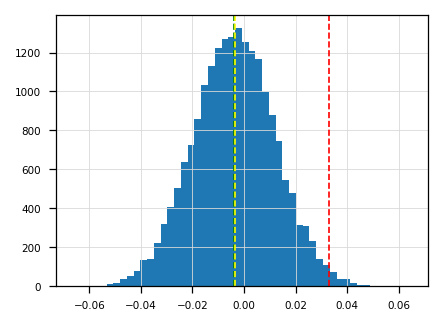

In [58]:
all_permutation_scores = pd.Series(permutation_scores.values.flatten())
all_permutation_scores.hist(bins=50)
plt.axvline(percentile_99, color='red', linestyle='--', label='99th Percentile')
plt.axvline(all_permutation_scores.mean(), color='green', linestyle='--', label='Mean')
plt.axvline(all_permutation_scores.median(), color='yellow', linestyle='--', label='Median')
print("Mean:", all_permutation_scores.mean())
print("Median:", all_permutation_scores.median())

In [59]:
permutation_scores

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bin,,,,,,,,,,,,,,,,,,,,,
5,-0.011194,0.013506,0.015313,-0.002090,-0.020407,-0.010854,-0.005901,-0.012279,-0.023434,0.019207,...,-0.004878,-0.018329,0.007820,0.017423,-0.012301,0.003047,0.019285,0.007616,0.013544,0.003945
20,-0.025985,-0.013506,-0.015944,-0.017257,-0.025555,0.018361,-0.023416,-0.020068,-0.013645,-0.028089,...,-0.009410,0.015500,0.006087,0.000772,-0.031765,-0.007904,0.008807,-0.003317,0.000900,-0.016696
55,-0.004052,-0.002070,-0.019451,0.027903,-0.018049,-0.013920,0.001644,0.008278,0.008987,-0.014768,...,0.005914,0.003680,-0.003916,-0.019473,0.002983,-0.013751,-0.013618,-0.030648,-0.011036,-0.040459
10,-0.001274,-0.007882,-0.019262,0.008235,0.008663,0.004286,0.000260,0.012564,0.014101,0.021396,...,-0.027885,0.039810,0.003640,-0.007669,0.009240,0.018883,-0.022528,-0.001884,-0.005027,-0.004254
30,-0.011490,-0.013739,-0.011168,-0.019815,0.015388,0.019728,-0.012981,0.000852,0.006758,-0.019004,...,0.009880,-0.004245,-0.017184,-0.000931,-0.004513,-0.014461,-0.023756,-0.027835,-0.023267,0.009981
15,0.012456,-0.024330,0.005404,0.010086,0.002068,-0.021077,0.013750,-0.007346,-0.008644,-0.007510,...,0.007863,-0.021883,-0.031200,0.002130,0.005908,0.016022,-0.021800,0.010831,-0.011968,-0.011857
50,-0.021575,0.004013,-0.016405,-0.006600,-0.005113,-0.025908,-0.002394,0.011968,0.003387,-0.003745,...,-0.030691,0.023112,0.008087,-0.006160,0.019423,0.015094,0.013058,-0.005507,0.000600,0.005865
25,0.002841,0.004269,-0.002372,-0.016194,0.013723,0.021055,-0.011288,0.023994,0.024173,0.021623,...,0.023143,0.011160,0.001977,-0.026207,0.056609,0.026541,-0.019901,0.004765,0.000925,0.014824
35,0.010984,-0.007714,0.012300,-0.017105,-0.009188,-0.021064,-0.023864,-0.017681,0.022371,-0.016906,...,-0.016344,-0.010090,0.000888,-0.030936,0.012013,0.023876,-0.009118,-0.011343,-0.001127,-0.009115


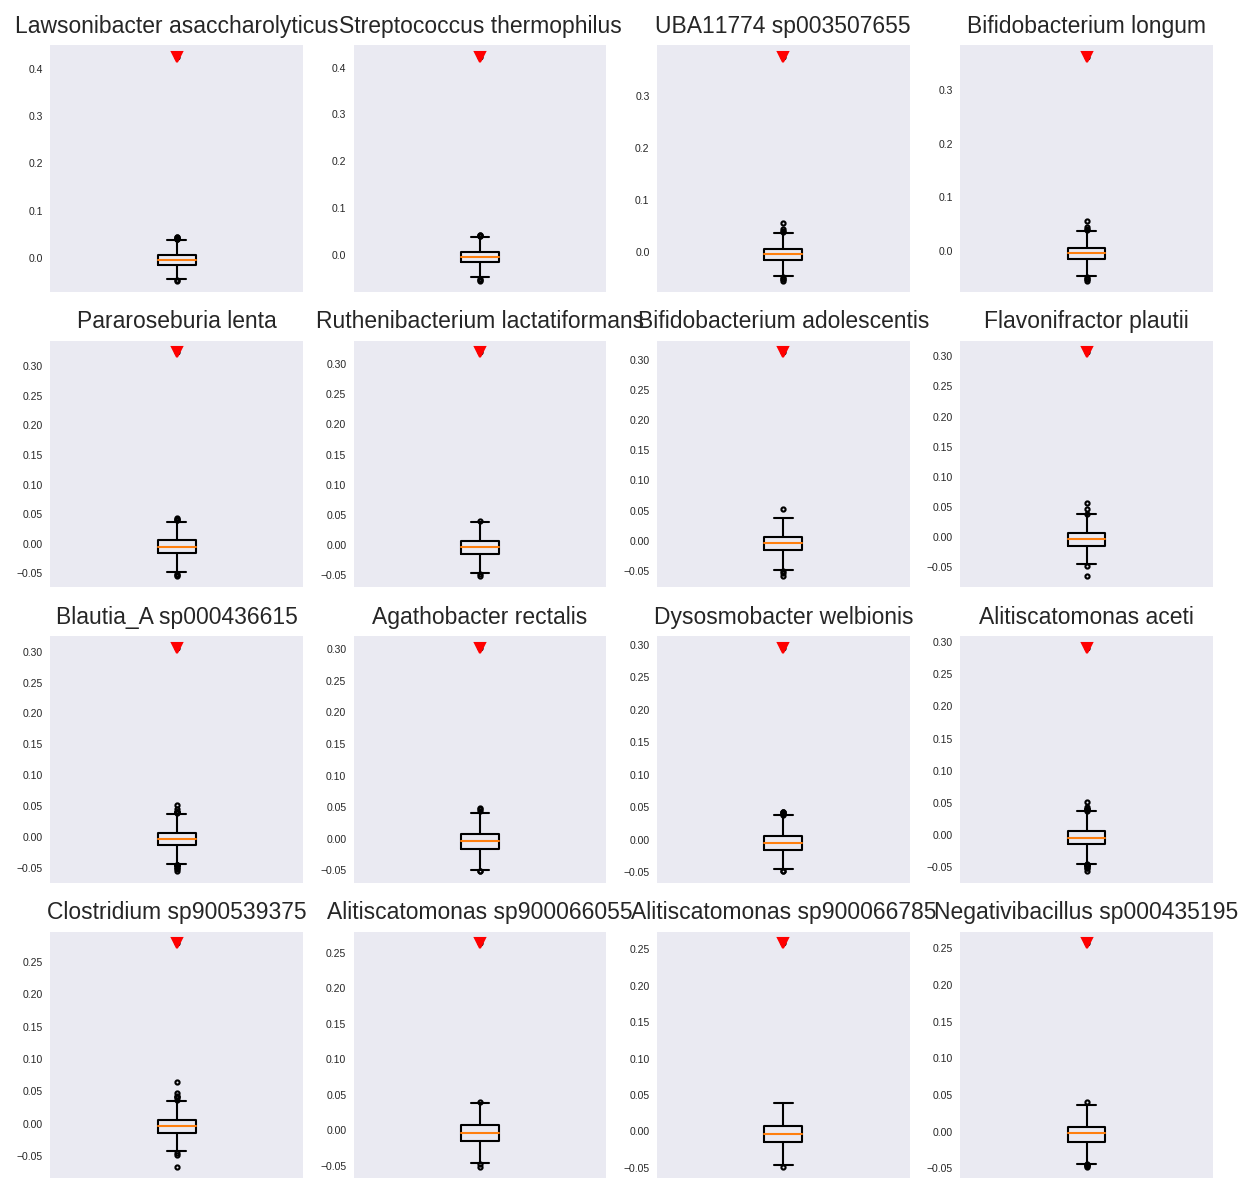

In [60]:
series_list = []
microbe_name_list = []

for microbe_index in top_microbes.index:
    bin = microbe_bin_mapping[targets_reformatted[microbe_index]]
    mic_perm_scores = permutation_scores.loc[bin]
    true_score = lgbm_diet_scores.loc[microbe_index]
    mic_scores = pd.concat([mic_perm_scores, pd.Series([true_score])], ignore_index=True)
    series_list.append(mic_scores)
    microbe_name_list.append(mb_names.loc[targets[microbe_index], 'species_new'])

# Plotting
plt.style.use('seaborn-dark')
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        axs[i, j].boxplot(series_list[i * 4 + j], flierprops=dict(markersize=2))
        true_score = series_list[i * 4 + j].iloc[-1]
        axs[i, j].plot(1, true_score, 'rv', markersize=5)
        axs[i, j].set_xticks([])
        axs[i, j].set_title(microbe_name_list[i * 4 + j], fontsize=11)


plt.show()

plt.style.use('default')

In [61]:

# 1. Create a results DataFrame with true scores and their corresponding bins
microbes_perm_scores = pd.DataFrame({'true_score': lgbm_diet_scores})
microbes_perm_scores.index = targets_reformatted
microbes_perm_scores['bin'] = microbes_perm_scores.index.map(microbe_bin_mapping)


# 2. Define a function to calculate the p-value for a single microbe (row)
def calculate_p_value(row):
    # Get the true score and bin for the microbe
    true_score = row['true_score']
    bin_id = row['bin']

    # Get the entire row of permutation scores for that bin
    perm_scores_for_bin = permutation_scores.loc[bin_id].values
    
    # Count how many permutation scores are >= the true score
    count_extreme = np.sum(perm_scores_for_bin >= true_score)
    
    # Get the total number of permutations
    total_permutations = len(perm_scores_for_bin)
    
    # Calculate the p-value using the (k+1)/(n+1) formula
    p_value = (count_extreme + 1) / (total_permutations + 1)
    
    return p_value


# 3. Apply the function to each row to calculate all p-values
microbes_perm_scores['p_value'] = microbes_perm_scores.apply(calculate_p_value, axis=1)

# 1. Define the FDR level (alpha)
fdr_level = 0.05

# 2. Apply the Benjamini/Hochberg FDR correction
reject, q_values, _, _ = multipletests(
    microbes_perm_scores['p_value'], 
    alpha=fdr_level, 
    method='fdr_bh'
)

# 3. Add the results back to your DataFrame
microbes_perm_scores['q_value'] = q_values
microbes_perm_scores['is_significant_fdr'] = reject # 'reject' is a boolean array (True/False)

# 4. Get the final list of significant targets after FDR correction
significant_targets_fdr = microbes_perm_scores[microbes_perm_scores['is_significant_fdr']].index.tolist()

# Display the results
print(f"Found {len(significant_targets_fdr)} significant targets after FDR adjustment (q < {fdr_level})")
print(significant_targets_fdr)

# You can also view the top results sorted by q-value
print("\n--- Results Summary with FDR ---")
print(microbes_perm_scores.sort_values('q_value').head())
print(microbes_perm_scores.sort_values('q_value').tail(10))

Found 664 significant targets after FDR adjustment (q < 0.05)
['fBin__100_gBin__473_sBin__693', 'fBin__100_gBin__473_sBin__694', 'fBin__100_gBin__477_sBin__698', 'fBin__100_gBin__481_sBin__704', 'fBin__100_gBin__481_sBin__705', 'fBin__100_gBin__481_sBin__706', 'fBin__100_gBin__483_sBin__709', 'fBin__102_gBin__490_sBin__721', 'fBin__102_gBin__490_sBin__722', 'fBin__103_gBin__491_sBin__727', 'fBin__104_gBin__493_sBin__730', 'fBin__104_gBin__496_sBin__733', 'fBin__104_gBin__498_sBin__736', 'fBin__104_gBin__500_sBin__738', 'fBin__108_gBin__515_sBin__766', 'fBin__108_gBin__515_sBin__767', 'fBin__108_gBin__517_sBin__769', 'fBin__108_gBin__521_sBin__773', 'fBin__108_gBin__523_sBin__776', 'fBin__108_gBin__525_sBin__778', 'fBin__108_gBin__526_sBin__779', 'fBin__108_gBin__531_sBin__787', 'fBin__121_gBin__564_sBin__834', 'fBin__121_gBin__566_sBin__836', 'fBin__121_gBin__568_sBin__838', 'fBin__121_gBin__568_sBin__840', 'fBin__121_gBin__568_sBin__841', 'fBin__121_gBin__568_sBin__842', 'fBin__121_gB

In [62]:
# # p value cutoff for p < 0.01
# microbes_perm_scores["true_scores"] = lgbm_diet_scores
# microbes_perm_scores['true_is_max'] = microbes_perm_scores.apply(lambda row: row['true_scores'] >= max(row.drop('true_scores')), axis=1)
# microbes_perm_scores['true_is_max'].sum()

In [63]:
# significant_targets = [target for target, m in zip(targets, microbes_perm_scores['true_is_max']) if m]
# print(targets)
# print(significant_targets)


In [64]:
# significant_targets_index = [index for index, (target, m) in enumerate(zip(targets, microbes_perm_scores['true_is_max'])) if m]
# print(targets)
# print(significant_targets_index)


In [65]:
indices = [targets_reformatted.index(item) for item in significant_targets_fdr]
significant_targets = [targets[i] for i in indices]
significant_targets

['fBin__100|gBin__473|sBin__693',
 'fBin__100|gBin__473|sBin__694',
 'fBin__100|gBin__477|sBin__698',
 'fBin__100|gBin__481|sBin__704',
 'fBin__100|gBin__481|sBin__705',
 'fBin__100|gBin__481|sBin__706',
 'fBin__100|gBin__483|sBin__709',
 'fBin__102|gBin__490|sBin__721',
 'fBin__102|gBin__490|sBin__722',
 'fBin__103|gBin__491|sBin__727',
 'fBin__104|gBin__493|sBin__730',
 'fBin__104|gBin__496|sBin__733',
 'fBin__104|gBin__498|sBin__736',
 'fBin__104|gBin__500|sBin__738',
 'fBin__108|gBin__515|sBin__766',
 'fBin__108|gBin__515|sBin__767',
 'fBin__108|gBin__517|sBin__769',
 'fBin__108|gBin__521|sBin__773',
 'fBin__108|gBin__523|sBin__776',
 'fBin__108|gBin__525|sBin__778',
 'fBin__108|gBin__526|sBin__779',
 'fBin__108|gBin__531|sBin__787',
 'fBin__121|gBin__564|sBin__834',
 'fBin__121|gBin__566|sBin__836',
 'fBin__121|gBin__568|sBin__838',
 'fBin__121|gBin__568|sBin__840',
 'fBin__121|gBin__568|sBin__841',
 'fBin__121|gBin__568|sBin__842',
 'fBin__121|gBin__571|sBin__846',
 'fBin__121|gB

In [66]:
with open(home_path + f'data/regression/{SPECIES}/significant_targets.pkl', 'wb') as file:
    pickle.dump(significant_targets, file)

In [67]:
# # p value cutoff for p < 0.01
# microbes_perm_scores["true_scores"] = lgbm_diet_scores
# microbes_perm_scores['true_is_max'] = microbes_perm_scores.apply(lambda row: row['true_scores'] >= max(row.drop('true_scores')), axis=1)
# microbes_perm_scores['true_is_max'].sum()

In [68]:
# significant_targets = [target for target, m in zip(targets, microbes_perm_scores['true_is_max']) if m]
# print(targets)
# print(significant_targets)


In [69]:
# significant_targets_index = [index for index, (target, m) in enumerate(zip(targets, microbes_perm_scores['true_is_max'])) if m]
# print(targets)
# print(significant_targets_index)


In [70]:
# with open(home_path + 'data/significant_targets.pkl', 'wb') as file:
#     pickle.dump(significant_targets, file)

In [71]:
# print(f"{len(significant_targets)} out of {len(targets)} LGBM predictions ({round((len(significant_targets)/len(targets))*100, 2)}) are significant with p value < 0.01")

In [72]:
# microbes_perm_scores['max'] = microbes_perm_scores.drop("true_is_max", axis=1).max(axis=1)
# random_max = microbes_perm_scores[~microbes_perm_scores['true_is_max']]
# print("Highest overall random score:", random_max['max'].max())

In [73]:
# microbes_perm_scores

In [74]:
# # Function to count correlations greater or equal to the true correlation
# def count_better_correlations(row):
#     true_corr = row['true_scores']
#     return sum(row[:-1] >= true_corr)

# microbes_perm_scores['better_perm_count'] = microbes_perm_scores.drop(["true_is_max", "max"], axis=1).apply(count_better_correlations, axis=1)

In [75]:
# microbes_perm_scores['better_perm_count']

In [76]:
# microbes_perm_scores['better_perm_count'][microbes_perm_scores['better_perm_count'] > 0]

#### Significant predictions in the baseline test set

In [77]:
pred_baseline_scores, pred_baseline_pvalues, pred_baseline_coefs, pred_baseline_preds, pred_baseline_targets = read_results(pd.read_pickle(home_path + f"data/regression/{SPECIES}/predictions_LGBM_abundance_baseline.pkl")) 
pred_baseline_scores

0      0.068938
1      0.059387
2      0.060565
3      0.135060
4      0.039714
         ...   
719    0.044922
720    0.101665
721    0.031756
722    0.037590
723    0.099890
Name: 0, Length: 724, dtype: float64

In [78]:

# 1. Create a results DataFrame with true scores and their corresponding bins
microbes_perm_scores = pd.DataFrame({'true_score': pred_baseline_scores})
microbes_perm_scores.index = targets_reformatted
microbes_perm_scores['bin'] = microbes_perm_scores.index.map(microbe_bin_mapping)


# 2. Define a function to calculate the p-value for a single microbe (row)
def calculate_p_value(row):
    # Get the true score and bin for the microbe
    true_score = row['true_score']
    bin_id = row['bin']

    # Get the entire row of permutation scores for that bin
    perm_scores_for_bin = permutation_scores.loc[bin_id].values
    
    # Count how many permutation scores are >= the true score
    count_extreme = np.sum(perm_scores_for_bin >= true_score)
    
    # Get the total number of permutations
    total_permutations = len(perm_scores_for_bin)
    
    # Calculate the p-value using the (k+1)/(n+1) formula
    p_value = (count_extreme + 1) / (total_permutations + 1)
    
    return p_value


# 3. Apply the function to each row to calculate all p-values
microbes_perm_scores['p_value'] = microbes_perm_scores.apply(calculate_p_value, axis=1)

# 1. Define the FDR level (alpha)
fdr_level = 0.05

# 2. Apply the Benjamini/Hochberg FDR correction
reject, q_values, _, _ = multipletests(
    microbes_perm_scores['p_value'], 
    alpha=fdr_level, 
    method='fdr_bh'
)

# 3. Add the results back to your DataFrame
microbes_perm_scores['q_value'] = q_values
microbes_perm_scores['is_significant_fdr'] = reject # 'reject' is a boolean array (True/False)

# 4. Get the final list of significant targets after FDR correction
significant_targets_fdr = microbes_perm_scores[microbes_perm_scores['is_significant_fdr']].index.tolist()

# Display the results
print(f"Found {len(significant_targets_fdr)} significant targets after FDR adjustment (q < {fdr_level})")
print(significant_targets_fdr)

# You can also view the top results sorted by q-value
print("\n--- Results Summary with FDR ---")
print(microbes_perm_scores.sort_values('q_value').head())
print(microbes_perm_scores.sort_values('q_value').tail(10))

Found 678 significant targets after FDR adjustment (q < 0.05)
['fBin__100_gBin__473_sBin__693', 'fBin__100_gBin__473_sBin__694', 'fBin__100_gBin__474_sBin__695', 'fBin__100_gBin__477_sBin__698', 'fBin__100_gBin__481_sBin__704', 'fBin__100_gBin__481_sBin__706', 'fBin__100_gBin__483_sBin__709', 'fBin__102_gBin__490_sBin__721', 'fBin__102_gBin__490_sBin__722', 'fBin__103_gBin__491_sBin__727', 'fBin__104_gBin__493_sBin__730', 'fBin__104_gBin__494_sBin__731', 'fBin__104_gBin__496_sBin__733', 'fBin__104_gBin__498_sBin__736', 'fBin__104_gBin__500_sBin__738', 'fBin__108_gBin__515_sBin__766', 'fBin__108_gBin__515_sBin__767', 'fBin__108_gBin__517_sBin__769', 'fBin__108_gBin__521_sBin__773', 'fBin__108_gBin__523_sBin__776', 'fBin__108_gBin__525_sBin__778', 'fBin__108_gBin__526_sBin__779', 'fBin__108_gBin__531_sBin__787', 'fBin__121_gBin__564_sBin__834', 'fBin__121_gBin__566_sBin__836', 'fBin__121_gBin__568_sBin__838', 'fBin__121_gBin__568_sBin__840', 'fBin__121_gBin__568_sBin__841', 'fBin__121_gB

#### Analyzing non-significant microbes

In [79]:
# non_significant_microbes = [target for target, m in zip(targets, microbes_perm_scores['true_is_max']) if not m]
# non_significant_microbes

In [80]:
# mb_names.loc[non_significant_microbes].to_csv("non_significant_microbes.csv", index=False)

In [81]:
# mb_names.loc[non_significant_microbes]

In [82]:
mb_names['phylum'].value_counts()

Firmicutes_A         487
Bacteroidota          86
Firmicutes            52
Proteobacteria        28
Actinobacteriota      25
Firmicutes_C          17
Verrucomicrobiota     14
Desulfobacterota       9
Cyanobacteria          5
Firmicutes_B           2
Methanobacteriota      1
Name: phylum, dtype: int64

## Plots

#### Overall results for Eran

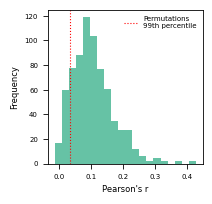

In [83]:
plt.style.use(third_style)
plt.figure()
plt.hist(lgbm_diet_scores, bins=20, color=palette[0])
# plt.hist(pred_baseline_scores, bins=20, color=palette[1], alpha=0.5)
plt.xlabel("Pearson's r")
plt.ylabel("Frequency")
plt.axvline(percentile_99, color='red', linestyle='dotted', linewidth=0.8, label="Permutations\n99th percentile")
# plt.title('Distribution of Correlation Values Across All Species', fontsize=12)
plt.legend()
plt.savefig(home_path +f"figures/regression/{SPECIES}/abundance_corr_distribution.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.savefig(home_path +f"figures/regression/{SPECIES}/abundance_corr_distribution.pdf", dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()

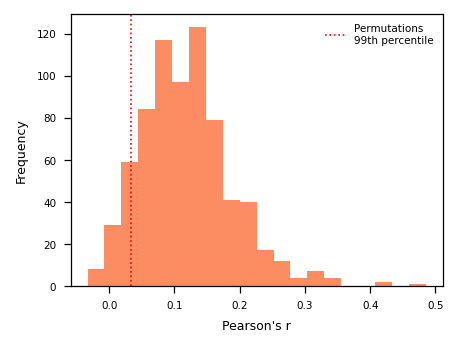

In [140]:
plt.style.use(single_style)
plt.figure()
# plt.hist(pred_baseline_scores, bins=20, color=palette[0])
plt.hist(pred_baseline_scores, bins=20, color=palette[1])
plt.xlabel("Pearson's r")
plt.ylabel("Frequency")
plt.axvline(percentile_99, color='red', linestyle='dotted', linewidth=0.8, label="Permutations\n99th percentile")
# plt.title('Distribution of Correlation Values Across All Species', fontsize=12)
plt.legend()
plt.savefig(home_path +f"figures/regression/{SPECIES}/abundance_corr_distribution_test.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.savefig(home_path +f"figures/regression/{SPECIES}/abundance_corr_distribution_test.pdf", dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()

In [85]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 1) set up figure & draw your histogram (bars at z=1)
# fig, ax = plt.subplots(figsize=(10, 5))
# counts, bins, patches = ax.hist(
#     lgbm_diet_scores,
#     bins=20,
#     edgecolor='black',
#     color='cadetblue',
#     zorder=1
# )

# # 2) compute a small y‐jitter band (e.g. up to 2% of the max bin height)
# max_count = counts.max()
# y_jitter = np.random.uniform(0, max_count * 0.02, size=len(all_permutation_scores))

# # 3) scatter the permutation scores at that band (on top of bars: z=2)
# ax.scatter(
#     all_permutation_scores,
#     y_jitter,
#     color='dimgray',
#     alpha=0.3,
#     s=3,
#     zorder=2
# )

# # 4) rest of your plot
# ax.set_xlabel("Pearson's Correlation", fontsize=10)
# ax.set_ylabel("Frequency")
# ax.axvline(
#     percentile_99,
#     color='red',
#     linestyle='dotted',
#     linewidth=2,
#     label="99th percentile of permutations",
#     zorder=3
# )
# ax.legend()

# # 5) save & show
# plt.savefig(
#     home_path + f"figures/regression/{SPECIES}/abundance_corr_distribution_perm.png",
#     dpi=400, facecolor="white", transparent=False
# )
# plt.show()


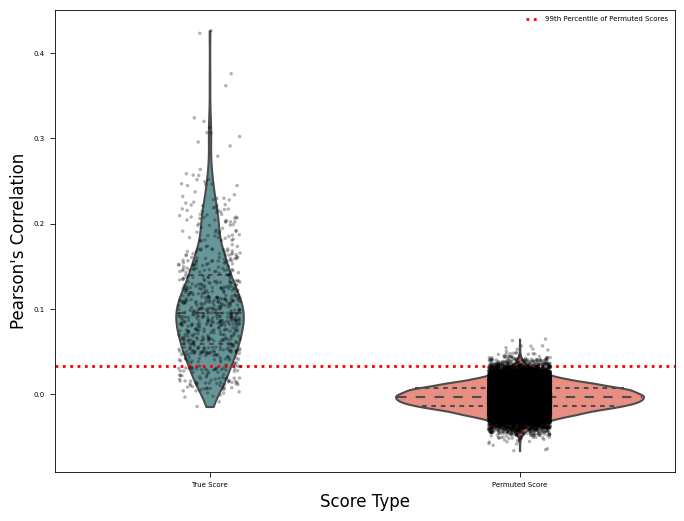

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Prepare your data ---
# Assume 'lgbm_diet_scores' and 'all_permutation_scores' are your data lists/arrays
true_scores_df = pd.DataFrame({
    'score': lgbm_diet_scores,
    'type': 'True Score'
})

perm_scores_df = pd.DataFrame({
    'score': all_permutation_scores,
    'type': 'Permuted Score'
})

# Combine into a single DataFrame for plotting
plot_df = pd.concat([true_scores_df, perm_scores_df])

# --- 2. Create the plot ---
plt.figure(figsize=(8, 6))

# Create the violin plot
# 'cut=0' trims the violins to the data range
# 'inner='quartile'' shows the quartiles inside the violins
ax = sns.violinplot(
    data=plot_df, 
    x='type', 
    y='score', 
    palette={'True Score': 'cadetblue', 'Permuted Score': 'salmon'},
    inner='quartile',
    cut=0,
    linewidth=1.5
)

# Overlay a strip plot to show individual data points
sns.stripplot(
    data=plot_df, 
    x='type', 
    y='score', 
    color='black', 
    size=2.5, 
    alpha=0.3,
    jitter=True, # Jitter points to reduce overlap
    ax=ax
)

# --- 3. Add significance line and labels ---
# Calculate the 99th percentile from the permuted scores
percentile_99 = np.percentile(all_permutation_scores, 99)

# Add a HORIZONTAL line for the percentile, since scores are now on the y-axis
ax.axhline(
    percentile_99, 
    color='red', 
    linestyle='dotted', 
    linewidth=2, 
    label="99th Percentile of Permuted Scores"
)

# Clean up the plot
# ax.set_title('Comparison of True and Permuted Score Distributions', fontsize=14)
ax.set_xlabel('Score Type', fontsize=12)
ax.set_ylabel("Pearson's Correlation", fontsize=12)
ax.legend()

# Display the plot
plt.show()

In [87]:
# neg_log_pvalues = -np.log10(lgbm_diet_pvalues_adj)

# # Creating the volcano plot
# plt.figure(figsize=(8, 6))
# plt.scatter(lgbm_diet_scores, neg_log_pvalues, c='gray', alpha=0.7)

# # Highlight significant points
# sig_threshold = 0.05
# highly_significant = lgbm_diet_pvalues_adj < sig_threshold
# plt.scatter(
#     lgbm_diet_scores[highly_significant], 
#     neg_log_pvalues[highly_significant], 
#     color='cadetblue', 
#     alpha=0.5,
#     label=f'p < {sig_threshold}'
# )

# # Adding labels and reference lines
# plt.axhline(-np.log10(sig_threshold), color='black', linestyle='--', label=f'-log10({sig_threshold})')
# plt.axvline(0, color='black', linestyle='-')
# plt.xlabel("LGBM Diet Scores (Effect Size)")
# plt.ylabel("-log10(p-value)")
# plt.title("Volcano Plot of LGBM Diet Scores")
# plt.legend()
# plt.show()

In [88]:
# series_list = []
# microbe_name_list = []
# mic_index_list = []

# for microbe_index in top_microbes.head(2).index:
#     mic_index_list.append(microbe_index)
#     mic_perm_scores = permutation_scores.loc[microbe_index]
#     true_score = lgbm_diet_scores.loc[microbe_index]
#     mic_scores = pd.concat([mic_perm_scores, pd.Series([true_score])], ignore_index=True)
#     series_list.append(mic_scores)
#     microbe_name_list.append(mb_names.loc[targets[microbe_index], 'species_new'])

# # Plotting
# # plt.style.use('seaborn-dark')
# print(lgbm_diet_preds)
# print(lgbm_diet_preds[mic_index_list[0]])
# print(len(lgbm_diet_preds[mic_index_list[0]]))
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# axs[0].scatter(x=lgbm_diet_targets[mic_index_list[0]], y=lgbm_diet_preds[mic_index_list[0]], alpha=0.1)
# axs[0].plot([-4, -1], [-4, -1], 'r--')
# axs[0].set_xticks(range(-4, 0))
# axs[0].set_yticks(range(-4, -2))
# axs[0].set_xlabel("Measured log-abundances", fontsize=12)
# axs[0].set_ylabel("Predicted log-abundances", fontsize=12)
# axs[0].set_title(microbe_name_list[0], fontsize=14)
# axs[0].text(0.5, 0.9, f"Pearson's correlation: {series_list[0].iloc[-1]:.2f}", transform=axs[0].transAxes, 
#                 ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
# slope, intercept, r_value, p_value, std_err = stats.linregress(lgbm_diet_targets[mic_index_list[0]], lgbm_diet_preds[mic_index_list[0]])
# x = np.array([min(lgbm_diet_targets[mic_index_list[0]]), max(lgbm_diet_targets[mic_index_list[0]])])
# y = slope * x + intercept
# axs[0].plot(x, y, color='red', label='Trendline')

# axs[1].scatter(x=lgbm_diet_targets[mic_index_list[1]], y=lgbm_diet_preds[mic_index_list[1]], alpha=0.1)
# axs[1].plot([-4, -1], [-4, -1], 'r--')
# axs[1].set_xticks(range(-4, 0))
# axs[1].set_yticks(range(-4, 0))
# axs[1].set_xlabel("Measured log-abundances", fontsize=12)
# axs[1].set_ylabel("Predicted log-abundances", fontsize=12)
# axs[1].set_title(microbe_name_list[1], fontsize=14)
# axs[1].text(0.5, 0.9, f"Pearson's correlation: {series_list[1].iloc[-1]:.2f}", transform=axs[1].transAxes, 
#                 ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
# slope, intercept, r_value, p_value, std_err = stats.linregress(lgbm_diet_targets[mic_index_list[1]], lgbm_diet_preds[mic_index_list[1]])
# x = np.array([min(lgbm_diet_targets[mic_index_list[1]]), max(lgbm_diet_targets[mic_index_list[1]])])
# y = slope * x + intercept
# axs[1].plot(x, y, color='red', label='Trendline')

# 
# plt.show()

# # plt.style.use('default')

In [89]:
# Creating mic_index_list and others, delete this block after uncommenting after permutations

series_list = []
microbe_name_list = []
mic_index_list = []

for microbe_index in top_microbes.head(2).index:
    mic_index_list.append(microbe_index)
    # mic_perm_scores = permutation_scores.loc[microbe_index]
    # true_score = lgbm_diet_scores.loc[microbe_index]
    # mic_scores = pd.concat([mic_perm_scores, pd.Series([true_score])], ignore_index=True)
    # series_list.append(mic_scores)
    if SPECIES == "segal_species":
        microbe_name_list.append(mb_names.loc[targets[microbe_index], 'species_new'])
    elif SPECIES == "mpa_species":
        microbe_name_list.append(targets[microbe_index])

In [90]:
pd.Series(lgbm_diet_preds[mic_index_list[0]]).sort_values()

845    -0.990788
3342   -0.983362
140    -0.968333
3572   -0.942851
4204   -0.923446
          ...   
747     0.556878
1568    0.559541
368     0.565248
5363    0.565269
5991    0.576797
Length: 8102, dtype: float64

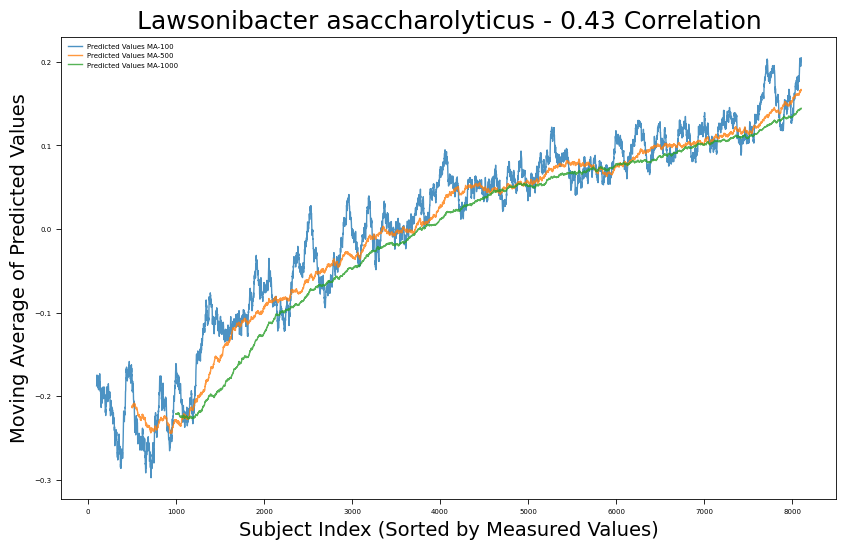

In [91]:

def moving_average(targets, preds, name):
    # Sorting by measured values to determine the order
    order_based_on_measured = np.argsort(targets)

    # Sorting predicted values based on the order determined by measured values
    sorted_predicted_values = pd.Series(preds)[order_based_on_measured]
    # Window sizes
    window_sizes = [100, 500, 1000]

    # Plotting moving averages for sorted predicted values
    plt.figure(figsize=(10, 6))
    for window_size in window_sizes:
        moving_avg = pd.Series(sorted_predicted_values).rolling(window=window_size).mean()
        plt.plot(moving_avg.reset_index(drop=True), label=f'Predicted Values MA-{window_size}', linewidth=1, alpha=0.8)

    # plt.title(f'Moving Window Average of Predicted Values - {name}')
    plt.title(f'{name}', fontsize=18)
    plt.xlabel('Subject Index (Sorted by Measured Values)', fontsize=14)
    plt.ylabel('Moving Average of Predicted Values', fontsize=14)
    plt.legend()
    plt.savefig(home_path + f"figures/regression/{SPECIES}/moving_average_{name}.png", dpi=400, facecolor="white", transparent=False)
    plt.show()

moving_average(lgbm_diet_targets[mic_index_list[0]], lgbm_diet_preds[mic_index_list[0]], microbe_name_list[0] + f" - {round(lgbm_diet_scores[mic_index_list[0]], 2)} Correlation")

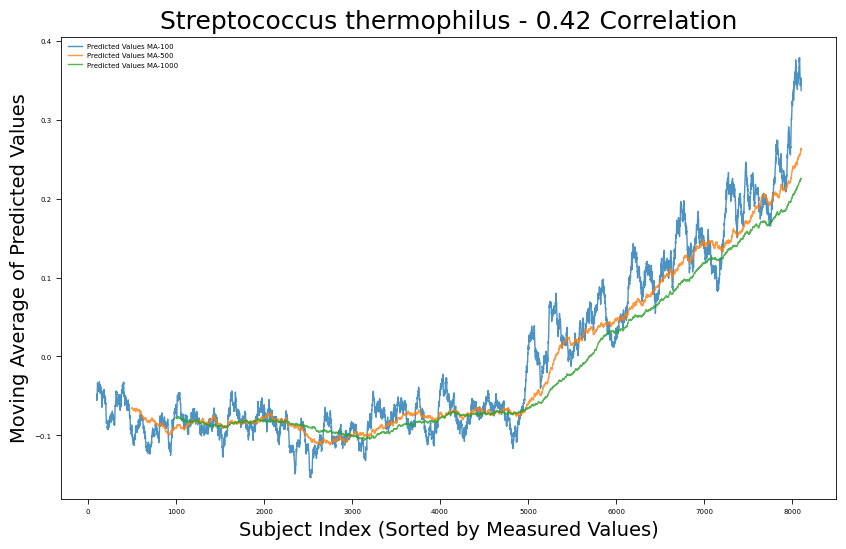

In [92]:
moving_average(lgbm_diet_targets[mic_index_list[1]], lgbm_diet_preds[mic_index_list[1]], microbe_name_list[1] + f" - {round(lgbm_diet_scores[mic_index_list[1]], 2)} Correlation")

In [93]:
lgbm_diet_scores.min()

-0.01457476508187076

In [94]:
# control_index = non_significant_scores.index[0]
# moving_average(lgbm_diet_targets[control_index], lgbm_diet_preds[control_index], f"Control Species - {round(lgbm_diet_scores[control_index], 2)} Correlation")

In [95]:
lgbm_div_targets

0    [-0.46735644850889857, 0.8857407203579445, -0....
1    [-0.046076166564277286, 0.7745169898797589, -0...
Name: 4, dtype: object

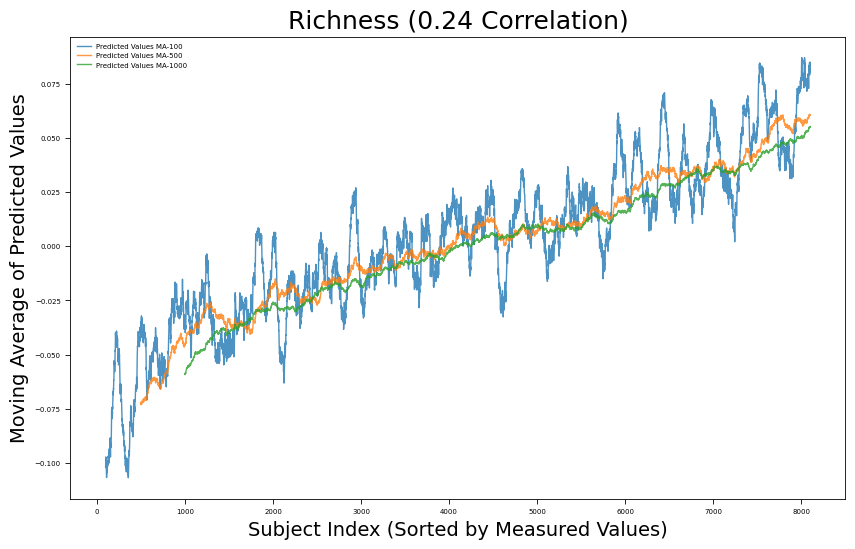

In [96]:
moving_average(lgbm_div_targets[0], lgbm_div_preds[0], f"Richness ({round(lgbm_div_scores[0], 2)} Correlation)")

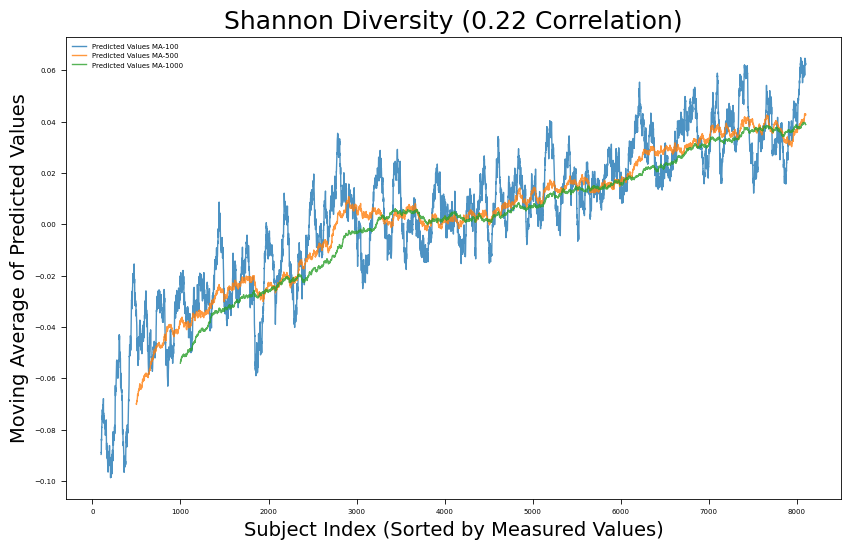

In [97]:
moving_average(lgbm_div_targets[1], lgbm_div_preds[1], f"Shannon Diversity ({round(lgbm_div_scores[1], 2)} Correlation)")

In [98]:
# series_list = []
# microbe_name_list = []
# mic_index_list = []

# for microbe_index in top_microbes.head(2).index:
#     mic_index_list.append(microbe_index)
#     mic_perm_scores = permutation_scores.loc[microbe_index]
#     true_score = lgbm_diet_scores.loc[microbe_index]
#     mic_scores = pd.concat([mic_perm_scores, pd.Series([true_score])], ignore_index=True)
#     series_list.append(mic_scores)
#     microbe_name_list.append(mb_names.loc[targets[microbe_index], 'species_new'])

# print(mic_index_list)
# # Plotting
# # plt.style.use('seaborn-dark')
# # fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 1]})
# # fig.delaxes(axs[0][1])

# fig = plt.figure(figsize=(12, 10))
# grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.3, height_ratios=[1, 1])

# # Histogram on the top spanning two columns
# ax_hist = fig.add_subplot(grid[0, :])
# ax_hist = fig.add_subplot(2, 2, (1, 2))
# ax_hist.hist(lgbm_diet_scores, bins=20, edgecolor='black')
# ax_hist.set_xlabel("Pearson's Correlation")
# ax_hist.set_ylabel("Frequency")
# ax_hist.axvline(percentile_99, color='red', linestyle='dotted', linewidth=2, label="99th percentile of permutations")
# ax_hist.set_title('Distribution of Correlation Values Across All Species')
# ax_hist.set_yticks([])
# ax_hist.set_yticks([])
# ax_hist.legend()
# ax_hist.yaxis.get_major_locator().set_params(nbins=6)

# ax_dot1 = fig.add_subplot(grid[1, 0])
# ax_dot1.scatter(x=lgbm_diet_targets[mic_index_list[0]], y=lgbm_diet_preds[mic_index_list[0]])
# ax_dot1.plot([-4, -1], [-4, -1], 'r--')
# ax_dot1.set_xticks(range(-4, 0))
# ax_dot1.set_yticks(range(-4, 0))
# ax_dot1.set_xlabel("Measured log-abundances")
# ax_dot1.set_ylabel("Predicted log-abundances")
# ax_dot1.set_title(microbe_name_list[0], fontsize=11)

# ax_dot2 = fig.add_subplot(grid[1, 1])
# ax_dot2.scatter(x=lgbm_diet_targets[mic_index_list[1]], y=lgbm_diet_preds[mic_index_list[1]])
# ax_dot2.plot([-4, -1], [-4, -1], 'r--')
# ax_dot2.set_xticks(range(-4, 0))
# ax_dot2.set_yticks(range(-4, 0))
# ax_dot2.set_xlabel("Measured log-abundances")
# ax_dot2.set_ylabel("Predicted log-abundances")
# ax_dot2.set_title(microbe_name_list[1], fontsize=11)

# 
# plt.show()

# # plt.style.use('default')

#### How do Ridge and LGBM scores compare?

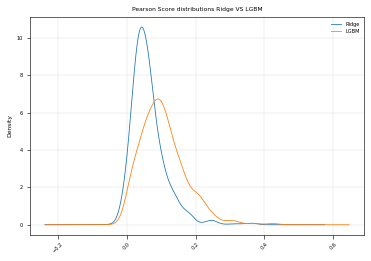

<Figure size 432x288 with 0 Axes>

In [99]:
%matplotlib inline

to_boxplot = pd.concat([ridge_diet_scores, lgbm_diet_scores] , axis=1)
to_boxplot.columns = ["Ridge", "LGBM"]
# to_boxplot.boxplot(flierprops=dict(markersize=2))
to_boxplot.plot.kde()
plt.title("Pearson Score distributions Ridge VS LGBM")
# plt.ylabel("Pearson Corr")
plt.xticks(rotation=45)
plt.grid()
plt.savefig(home_path +f"figures/regression/{SPECIES}/ridge_vs_lgbm_dist.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

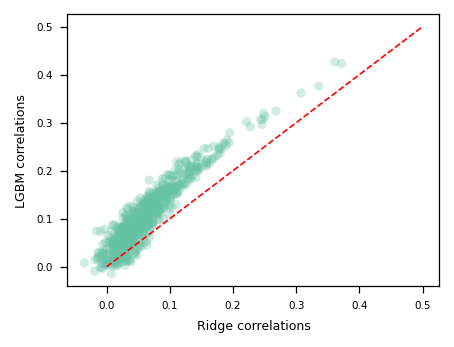

<Figure size 480x360 with 0 Axes>

In [137]:
# Compare Ridge vs LGBM (styled like the longitudinal plot)
plt.style.use(single_style)

# Mann–Whitney U keeps your original test (two-sided)
U, p = stats.mannwhitneyu(ridge_diet_scores, lgbm_diet_scores, alternative='two-sided')

# Assemble and clean
to_plot = pd.concat([ridge_diet_scores, lgbm_diet_scores], axis=1).dropna()
to_plot.columns = ["Ridge correlations", "LGBM correlations"]

# Pearson correlation for the annotation
r_val = to_plot["Ridge correlations"].corr(to_plot["LGBM correlations"], method="pearson")

# Scatter in the same style: color1, alpha=0.3, no edgecolor
to_plot.plot.scatter(
    "Ridge correlations",
    "LGBM correlations",
    color=color1,
    alpha=0.3,
    edgecolor="none"
)

# y = x reference line (same look)
plt.plot([0, 0.5], [0, 0.5], 'r--')

# Annotate in the bottom-right with r and p
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
# plt.text(
#     x1 - 0.05 * (x1 - x0),
#     y0 + 0.04 * (y1 - y0),
#     f'$r = {r_val:.2f}$\np-value: {p:.2e}',
#     ha='right', va='bottom',
#     bbox=dict(facecolor='white', edgecolor='white')
# )

# Save as PDF with tight bbox, white facecolor
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/ridge_vs_lgbm_scatter.png",
    dpi=400,
    facecolor="white",
    transparent=False,
    bbox_inches='tight'
)
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/ridge_vs_lgbm_scatter.pdf",
    dpi=400,
    facecolor="white",
    transparent=False,
    bbox_inches='tight',
    format='pdf'
)
plt.show()
plt.clf()


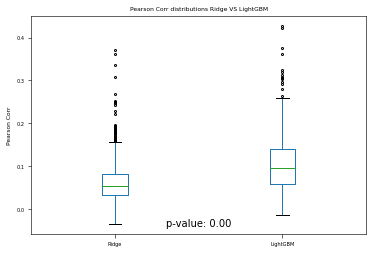

<Figure size 432x288 with 0 Axes>

In [101]:
# Ridge VS LightGBM
U, p = stats.mannwhitneyu(ridge_diet_scores, lgbm_diet_scores, alternative='two-sided')
to_boxplot = pd.concat([ridge_diet_scores, lgbm_diet_scores] , axis=1)
to_boxplot.columns = ["Ridge", "LightGBM"]
to_boxplot.boxplot(flierprops=dict(markersize=2))
plt.title("Pearson Corr distributions Ridge VS LightGBM")
plt.ylabel("Pearson Corr")
# plt.xticks(rotation=45)
plt.grid()
plt.text(1.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path +f"figures/regression/{SPECIES}/ridge_vs_lgbm_dist_box.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

### How do age and gender compare?

#### Diversity targets

               Age + Gender  All features
Richness           0.049235      0.240181
Shannon Index      0.082398      0.215410


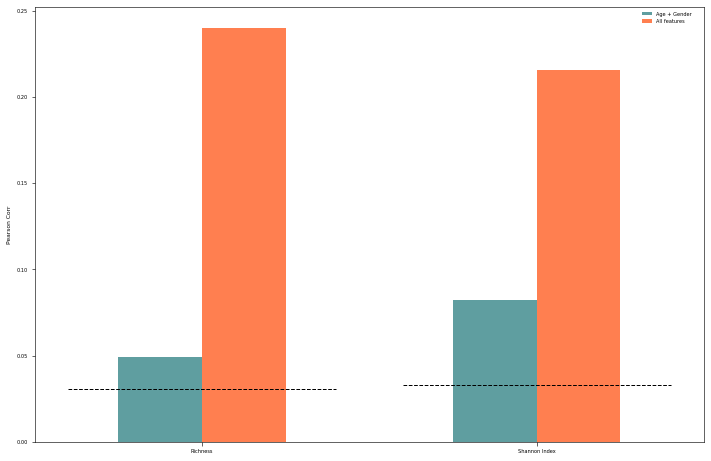

<Figure size 432x288 with 0 Axes>

In [102]:
lgbm_div_scores = pd.Series(lgbm_div_scores)
lgbm_base_scores_div = pd.Series(lgbm_base_scores_div)

to_plot = pd.concat([lgbm_base_scores_div, lgbm_div_scores] , axis=1)
to_plot.columns = ["Age + Gender", "All features"]
to_plot.index = ["Richness", "Shannon Index"]
print(to_plot)
ax = to_plot.plot(kind="bar", legend=True, figsize=(12, 8), alpha=1, color=["cadetblue", "coral"])
# plt.title("Diversity Targets")
plt.ylabel("Pearson Corr")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.9, 1.0), loc='upper left')


# Calculate bar positions
bar_positions = range(len(to_plot))  # x-positions for the bars (0 for Richness, 1 for Shannon)

# Add separate horizontal lines for each index
percentile_99_richness = np.percentile(richness_perm_scores.values.flatten(), 99)
percentile_99_shannon = np.percentile(shannon_perm_scores.values.flatten(), 99)

# Horizontal line for Richness
ax.plot(
    [bar_positions[0] - 0.4, bar_positions[0] + 0.4],  # x-range covering the Richness bar
    [percentile_99_richness, percentile_99_richness],  # y-values for the horizontal line
    color='black', linestyle='--', linewidth=1, label="99th percentile (Richness)"
)

# Horizontal line for Shannon Index
ax.plot(
    [bar_positions[1] - 0.4, bar_positions[1] + 0.4],  # x-range covering the Shannon Index bar
    [percentile_99_shannon, percentile_99_shannon],  # y-values for the horizontal line
    color='black', linestyle='--', linewidth=1, label="99th percentile (Shannon)"
)

# # Annotate the lines
# plt.text(bar_positions[0], percentile_99_richness + 0.01, f"{percentile_99_richness:.2f}", color='black', fontsize=10, ha='center')
# plt.text(bar_positions[1], percentile_99_shannon + 0.01, f"{percentile_99_shannon:.2f}", color='black', fontsize=10, ha='center')

# to_boxplot.plot.box()
plt.savefig(home_path +f"figures/regression/{SPECIES}/diversity_corr_lgbm_base_diet.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

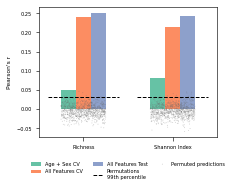

<Figure size 230.4x172.8 with 0 Axes>

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # make sure this is imported
from matplotlib.lines import Line2D

# --- convert your raw arrays into Series ---
lgbm_div_scores        = pd.Series(lgbm_div_scores)
lgbm_base_scores_div   = pd.Series(lgbm_base_scores_div)
lgbm_div_scores_test   = pd.Series(lgbm_div_scores_test)

# --- build the bar‐chart DataFrame ---
to_plot = pd.concat([lgbm_base_scores_div, lgbm_div_scores, lgbm_div_scores_test], axis=1)
to_plot.columns = ["Age + Sex CV", "All Features CV", "All Features Test"]
to_plot.index   = ["Richness", "Shannon Index"]

# --- build the permutation DataFrame ---
richness_df = pd.DataFrame({
    'score': richness_perm_scores.values.flatten(),
    'Target': 'Richness'
})
shannon_df = pd.DataFrame({
    'score': shannon_perm_scores.values.flatten(),
    'Target': 'Shannon Index'
})
perm_scores_df = pd.concat([richness_df, shannon_df], ignore_index=True)

# --- start plotting ---
plt.style.use(single_style)
fig, ax = plt.subplots() # Use subplots to get fig and ax explicitly
palette = sns.color_palette("Set2", n_colors=3)
# 1) the bars (low z-order)
to_plot.plot(kind="bar", legend=True, color=palette, ax=ax, zorder=1)

# 2) the permuted-score dots
sns.stripplot(
    x='Target', y='score', data=perm_scores_df, ax=ax,
    jitter=0.25, alpha=0.3, color='dimgray', s=1,
    order=["Richness", "Shannon Index"], zorder=2,
    label='Permuted predictions'  # <-- add label
)

# 3) 99th percentile lines
bar_positions = np.arange(len(to_plot))
p99_r = np.percentile(richness_perm_scores.values.flatten(), 99)
p99_s = np.percentile(shannon_perm_scores.values.flatten(), 99)

# Richness line - give it the legend label
ax.plot(
    [bar_positions[0] - 0.4, bar_positions[0] + 0.4],
    [p99_r, p99_r],
    linestyle='--', linewidth=1, color='black', zorder=3,
    label='Permutations\n99th percentile'  # <-- add label
)

# Shannon line - no legend entry
ax.plot(
    [bar_positions[1] - 0.4, bar_positions[1] + 0.4],
    [p99_s, p99_s],
    linestyle='--', linewidth=1, color='black', zorder=3,
    label='_nolegend_'  # <-- avoid duplicate legend item
)

# ... your grid and labels ...
ax.set_ylabel("Pearson's r")
ax.set_xticklabels(to_plot.index, rotation=0)

# Build a single legend and dedupe entries
handles, labels = ax.get_legend_handles_labels()
# Split into bar handles vs permutation handles
bar_handles, bar_labels = [], []
perm_handles, perm_labels = [], []

for h, l in zip(handles, labels):
    if l in ["Permuted predictions", "Permutations\n99th percentile"]:
        perm_handles.append(h)
        perm_labels.append(l)
    elif l != "_nolegend_":
        bar_handles.append(h)
        bar_labels.append(l)

# Put bar entries first, then permutation entries
final_handles = bar_handles + perm_handles
final_labels  = bar_labels + perm_labels

# De-duplicate legend entries (keep first occurrence)
seen = set()
dedup_handles, dedup_labels = [], []
for h, l in zip(final_handles, final_labels):
    if l != "_nolegend_" and l not in seen:
        dedup_handles.append(h)
        dedup_labels.append(l)
        seen.add(l)

# # Place the legend outside (works well for panel a)
# ax.legend(
#     dedup_handles, dedup_labels,
#     # loc="upper left", bbox_to_anchor=(1.02, 1.0),
#     loc="upper right", bbox_to_anchor=(-0.1, 1.0),
#     borderaxespad=0, frameon=False, fontsize=5
# )



# Legend below:
ax.legend(
    dedup_handles, dedup_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)

ax.set_xlabel('')

# standardize_panel(ax, inner_size=(2.2, 1.6))

# # save & show
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/diversity_corr_lgbm_base_diet.png",
    dpi=400, facecolor="white", transparent=False, bbox_inches='tight'
)
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/diversity_corr_lgbm_base_diet.pdf",
    dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf'
)
plt.show()
plt.clf()


#### Abundance targets

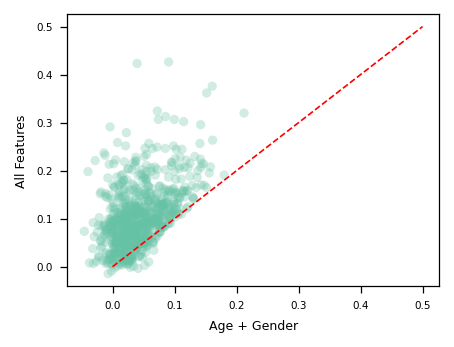

<Figure size 480x360 with 0 Axes>

In [138]:
# Age+Gender vs All Features (styled like the longitudinal plot)

# Mann-Whitney U (two-sided), as in your original
U, p = stats.mannwhitneyu(lgbm_base_scores, lgbm_diet_scores, alternative='two-sided')

# Assemble and clean
to_plot = pd.concat([lgbm_base_scores, lgbm_diet_scores], axis=1).dropna()
to_plot.columns = ["Age + Gender", "All Features"]

# Pearson r for annotation
r_val = to_plot["Age + Gender"].corr(to_plot["All Features"], method="pearson")

# Scatter with the same style: color1, alpha=0.3, no edgecolor
to_plot.plot.scatter(
    "Age + Gender",
    "All Features",
    color=color1,
    alpha=0.3,
    edgecolor="none"
)

# y = x reference line
plt.plot([0, 0.5], [0, 0.5], 'r--')

# Annotation box in bottom-right
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
# plt.text(
#     x1 - 0.05 * (x1 - x0),
#     y0 + 0.04 * (y1 - y0),
#     f'$r = {r_val:.2f}$\np-value: {p:.2e}',
#     ha='right', va='bottom',
#     bbox=dict(facecolor='white', edgecolor='white')
# )

# Save as PDF with tight bbox, white facecolor
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/lgbm_base_diet_scatter.png",
    dpi=400,
    facecolor="white",
    transparent=False,
    bbox_inches='tight'
)
plt.savefig(
    home_path + f"figures/regression/{SPECIES}/lgbm_base_diet_scatter.pdf",
    dpi=400,
    facecolor="white",
    transparent=False,
    bbox_inches='tight',
    format='pdf'
)
plt.show()
plt.clf()


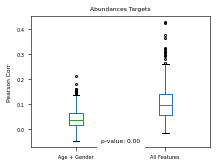

<Figure size 230.4x172.8 with 0 Axes>

In [105]:
U, p = stats.mannwhitneyu(lgbm_base_scores, lgbm_diet_scores, alternative='two-sided')
to_boxplot = pd.concat([lgbm_base_scores, lgbm_diet_scores] , axis=1)
to_boxplot.columns = ["Age + Gender", "All Features"]
to_boxplot.boxplot(flierprops=dict(markersize=2))
plt.title("Abundances Targets")
plt.ylabel("Pearson Corr")
# plt.xticks(rotation=45)
plt.grid()
plt.text(1.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path +f"figures/regression/{SPECIES}/lgbm_base_diet_boxplots.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

Comparison to CLR transformed predictions

In [106]:
# lgbm_diet_scores_CLR, lgbm_diet_pvalues_CLR, lgbm_diet_coefs_CLR, lgbm_diet_preds_CLR, lgbm_diet_targets_CLR = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_abundance_CLR.pkl"))

In [107]:
# U, p = stats.mannwhitneyu(lgbm_diet_scores, lgbm_diet_scores_CLR, alternative='two-sided')
# to_plot = pd.concat([lgbm_diet_scores, lgbm_diet_scores_CLR] , axis=1)
# to_plot.columns = ["Relative Abundance", "CLR transformed RA"]
# to_plot.plot.scatter("Relative Abundance", "CLR transformed RA", c='cadetblue', edgecolors='none', alpha=0.5)
# # plt.title("Abundances Targets")
# plt.plot([0, 0.5], [0, 0.5], 'r--')
# # plt.grid()
# # plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
# plt.savefig(home_path +f"figures/regression/{SPECIES}/CLR_vs_RA.SVG", dpi=400, facecolor="white", transparent=False)
# plt.show()
# plt.clf()

In [108]:
# # Improvement from RA to CLR
# delta = pd.Series(lgbm_diet_scores_CLR) - pd.Series(lgbm_diet_scores)
# delta.describe()

In [109]:
print("Number of microbes with better CLR prediction: ", delta[delta > 0].shape[0])
print("Number of microbes with better RA prediction: ", delta[delta < 0].shape[0])

Number of microbes with better CLR prediction:  678
Number of microbes with better RA prediction:  46


Comparison to food shortnames only predictions

In [110]:
lgbm_diet_scores_foods, lgbm_diet_pvalues_foods, lgbm_diet_coefs_foods, lgbm_diet_preds_foods, lgbm_diet_targets_foods = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_abundance_foods_only.pkl"))

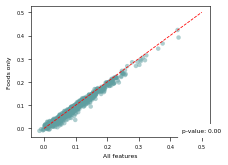

<Figure size 230.4x172.8 with 0 Axes>

In [111]:
U, p = stats.mannwhitneyu(lgbm_diet_scores, lgbm_diet_scores_foods, alternative='two-sided')
to_plot = pd.concat([lgbm_diet_scores, lgbm_diet_scores_foods] , axis=1)
to_plot.columns = ["All features", "Foods only"]
to_plot.plot.scatter("All features", "Foods only", c='cadetblue', edgecolors='none', alpha=0.5)
# plt.title("Abundances Targets")
plt.plot([0, 0.5], [0, 0.5], 'r--')
# plt.grid()
plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path +f"figures/regression/{SPECIES}/foods_only_VS_all_features.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

In [112]:
# Improvement from RA to CLR
delta = pd.Series(lgbm_diet_scores) - pd.Series(lgbm_diet_scores_foods)
delta.describe()

count    724.000000
mean       0.009048
std        0.010362
min       -0.018722
25%        0.002163
50%        0.007807
75%        0.015174
max        0.062326
Name: 0, dtype: float64

In [113]:
print("Number of microbes with better foods-only prediction: ", delta[delta > 0].shape[0])
print("Number of microbes with better all features prediction: ", delta[delta < 0].shape[0])

Number of microbes with better foods-only prediction:  594
Number of microbes with better all features prediction:  130


#### Health targets

                           Age + Gender  All features
modified_HACK_top17_score      0.068852      0.139548
GMWI2_score                    0.086385      0.217574


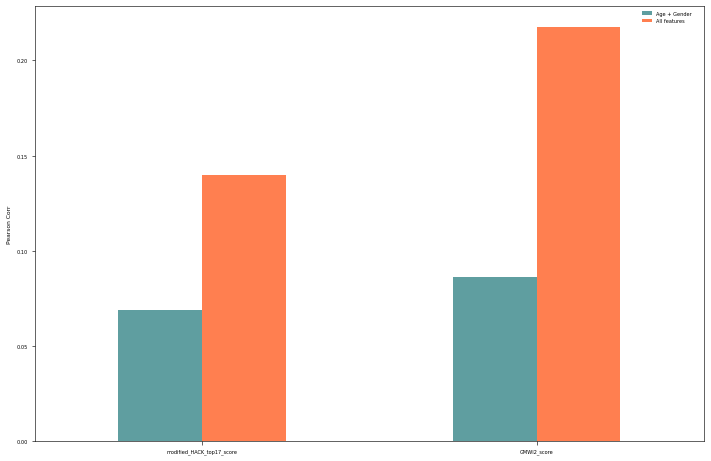

<Figure size 230.4x172.8 with 0 Axes>

In [114]:
lgbm_health_scores = pd.Series(lgbm_health_scores)
lgbm_base_scores_health = pd.Series(lgbm_base_scores_health)

to_plot = pd.concat([lgbm_base_scores_health, lgbm_health_scores] , axis=1)
to_plot.columns = ["Age + Gender", "All features"]
to_plot.index = ['modified_HACK_top17_score', 'GMWI2_score']
print(to_plot)
ax = to_plot.plot(kind="bar", legend=True, figsize=(12, 8), alpha=1, color=["cadetblue", "coral"])
# plt.title("Diversity Targets")
plt.ylabel("Pearson Corr")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.9, 1.0), loc='upper left')


# Calculate bar positions
bar_positions = range(len(to_plot))  # x-positions for the bars (0 for Richness, 1 for Shannon)

plt.savefig(home_path +f"figures/regression/{SPECIES}/health_corr_lgbm_base_diet.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

#### Comparison between previous features and new features (150 nutrients and dietary patterns)

In [115]:
# prev_diet_score, prev_diet_pvalues, prev_diet_coefs, prev_diet_fnames, prev_diet_preds, prev_diet_targets = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/lightGBM_output_microbes_v2.pkl"))
# prev_diet_score = pd.Series(prev_diet_score)

# U, p = stats.mannwhitneyu(prev_diet_score, lgbm_diet_scores, alternative='two-sided')
# to_plot = pd.concat([prev_diet_score, lgbm_diet_scores] , axis=1)
# to_plot.columns = ["Previous", "New"]
# to_plot.plot.scatter("Previous", "New", alpha=0.5, color='cadetblue')
# plt.title("Pearson Correlation Previous VS New Features (150 nutrients and dietary patterns)")
# plt.plot([0, 1], [0, 1], 'r--')
# # plt.grid()
# plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
# plt.savefig(home_path +f"figures/regression/{SPECIES}/prev_vs_new_features.png", dpi=400, facecolor="white", transparent=False)
# plt.show()
# plt.clf()

Improvement from adding variance features and macros

In [116]:
# # Improvement from adding variance features and macros
# lgbm_diet_scores_no_var_features, _, _, _, _  = read_results(pd.read_pickle(home_path +f"data/regression/{SPECIES}/output_LGBM_abundance_no_var_features.pkl"))
# delta = pd.Series(lgbm_diet_scores) - pd.Series(lgbm_diet_scores_no_var_features)
# delta.describe()

In [117]:

# lgbm_diet_scores_no_var_features = pd.Series(lgbm_diet_scores_no_var_features)

# U, p = stats.mannwhitneyu(lgbm_diet_scores_no_var_features, lgbm_diet_scores, alternative='two-sided')
# to_plot = pd.concat([lgbm_diet_scores_no_var_features, lgbm_diet_scores] , axis=1)
# to_plot.columns = ["Previous", "New"]
# to_plot.plot.scatter("Previous", "New", alpha=0.5, color='cadetblue')
# plt.title("Pearson Correlation Previous VS New Features (var features and macros)")
# plt.plot([0, 1], [0, 1], 'r--')
# # plt.grid()
# plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
# # plt.savefig(home_path +f"figures/regression/{SPECIES}/", dpi=400, facecolor="white", transparent=False)
# plt.show()
# plt.clf()

In [118]:
# # Improvement from adding variance features and macros
# lgbm_diet_scores_div_no_var_features, _, _, _, _  = read_results(pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/test/output_LGBM_div_no_var_features.pkl"))
# delta = pd.Series(lgbm_div_scores) - pd.Series(lgbm_diet_scores_div_no_var_features)
# delta.describe()

In [119]:

# lgbm_diet_scores_div_no_var_features = pd.Series(lgbm_diet_scores_div_no_var_features)

# U, p = stats.mannwhitneyu(lgbm_diet_scores_div_no_var_features, lgbm_div_scores, alternative='two-sided')
# to_plot = pd.concat([lgbm_diet_scores_div_no_var_features, lgbm_div_scores] , axis=1)
# to_plot.columns = ["Previous", "New"]
# to_plot.plot.scatter("Previous", "New", alpha=0.5, color='cadetblue')
# plt.title("Diversity Pearson Correlation Previous VS New Features (var features and macros)")
# plt.plot([0, 1], [0, 1], 'r--')
# # plt.grid()
# plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
# # plt.savefig(home_path +f"figures/regression/{SPECIES}/", dpi=400, facecolor="white", transparent=False)
# plt.show()
# plt.clf()

#### What is the corr diference between the highly predicted microbes in LGBM and Ridge?
Maybe those with high signal will show a significant difference between the models.

In [120]:
highly_pred_microbes_lgbm = lgbm_diet_scores.sort_values(ascending=False)
highly_pred_microbes_lgbm = highly_pred_microbes_lgbm[highly_pred_microbes_lgbm > 0.2]
highly_pred_microbes_lgbm

594    0.426409
46     0.423344
223    0.376008
34     0.361910
221    0.324238
         ...   
319    0.203653
575    0.202805
99     0.202267
279    0.202092
195    0.201737
Name: 0, Length: 65, dtype: float64

In [121]:
highly_pred_microbes_ridge = ridge_diet_scores.sort_values(ascending=False)
highly_pred_microbes_ridge = highly_pred_microbes_ridge[highly_pred_microbes_ridge > 0.2]
highly_pred_microbes_ridge

46     0.371747
594    0.361316
223    0.335828
34     0.307563
221    0.268004
32     0.250889
507    0.248568
309    0.247312
579    0.246078
586    0.243498
201    0.227462
237    0.221373
Name: 0, dtype: float64

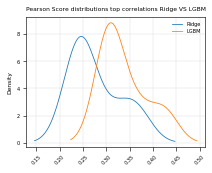

<Figure size 230.4x172.8 with 0 Axes>

In [122]:
# Top predictions Ridge vs LGBM KDE

to_boxplot = pd.concat([highly_pred_microbes_ridge, highly_pred_microbes_lgbm] , axis=1).dropna()
to_boxplot.columns = ["Ridge", "LGBM"]
# to_boxplot.boxplot(flierprops=dict(markersize=2))
to_boxplot.plot.kde()
plt.title("Pearson Score distributions top correlations Ridge VS LGBM")
# plt.ylabel("Pearson Corr")
plt.xticks(rotation=45)
plt.grid()
plt.savefig(home_path +f"figures/regression/{SPECIES}/ridge_vs_lgbm_dist_top_corr_kde.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

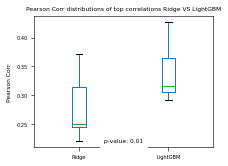

<Figure size 230.4x172.8 with 0 Axes>

In [123]:
# Top prediction Ridge VS LightGBM boxplot
to_boxplot = pd.concat([highly_pred_microbes_ridge, highly_pred_microbes_lgbm] , axis=1).dropna()
U, p = stats.mannwhitneyu(highly_pred_microbes_ridge, highly_pred_microbes_lgbm, alternative='two-sided')
to_boxplot.columns = ["Ridge", "LightGBM"]
to_boxplot.boxplot(flierprops=dict(markersize=2))
plt.title("Pearson Corr distributions of top correlations Ridge VS LightGBM")
plt.ylabel("Pearson Corr")
# plt.xticks(rotation=45)
plt.grid()
plt.text(1.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path +f"figures/regression/{SPECIES}/ridge_vs_lgbm_dist_top_corr_box.png", dpi=400, facecolor="white", transparent=False)
plt.show()
plt.clf()

#### Robustness Check

In [124]:
import glob

def _build_sample_grid(N):
    return sorted({min(N, int(s)) for s in [250, 500, 1000, 2000, 4000, 6000, N]})

def read_robustness(TARGETS):
    """
    Returns:
      results_by_size: dict[int, list[pd.DataFrame]]  # all repeats for each size
      samples:         list[int]                      # the grid
    """
    train_path = (
        f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/"
        f"data/{SPECIES}/diet_mb_baseline_train.pkl"
    )
    N = len(pd.read_pickle(train_path))
    samples = _build_sample_grid(N)

    results_by_size = {}
    for n in samples:
        pattern = (
            f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/"
            f"data/regression/{SPECIES}/"
            f"output_LGBM_{TARGETS}_robust_{n}_rep*.pkl"
        )
        files = sorted(glob.glob(pattern))
        if not files:
            print(f"[read_robustness] Warning: no robustness files found for n={n}")
            results_by_size[n] = []
            continue
        dfs = [pd.read_pickle(fp) for fp in files]
        results_by_size[n] = dfs
        print(f"[read_robustness] n={n} repeats={len(dfs)}")
    return results_by_size, samples


def _safe_first_nan_idx(seq):
    arr = np.asarray(seq, dtype=float)
    mask = np.isnan(arr)
    return int(np.argmax(mask)) if mask.any() else len(arr)

def robustness_calc(results_by_size, samples, TARGETS):
    """
    Aggregates across repeats for each sample size and returns means and SEMs.
    SEM is computed as SD / sqrt(n_repeats) with ddof=1 for SD.
    Returns:
      TARGETS == "div":
        rich_mean, rich_sem, shan_mean, shan_sem, iterations, valid_samples
      TARGETS in {"abundance","pathways"}:
        means, sems, iterations, valid_samples
    """
    def _unpack_result(df):
        cols = list(df.columns)
        return tuple(df[c] for c in cols)

    def _first_nan_idx(seq):
        arr = np.asarray(seq, dtype=float)
        mask = np.isnan(arr)
        return int(np.argmax(mask)) if mask.any() else len(arr)

    if TARGETS == "div":
        rich_mean, rich_sem = [], []
        shan_mean, shan_sem = [], []
        valid_samples = []

        for n in samples:
            dfs = results_by_size.get(n, [])
            if not dfs:
                continue

            rich_vals, shan_vals = [], []
            for df in dfs:
                res = _unpack_result(df)  # (scores, pvals, coefs, preds, targets) for regression
                scores = pd.Series(res[0], dtype="float64")
                if len(scores) >= 2:
                    rich_vals.append(scores.iloc[0])
                    shan_vals.append(scores.iloc[1])

            if len(rich_vals) == 0:
                continue

            # Means
            r_mean = float(np.nanmean(rich_vals))
            s_mean = float(np.nanmean(shan_vals))

            # SEMs
            r_sd = float(np.nanstd(rich_vals, ddof=1)) if len(rich_vals) > 1 else np.nan
            s_sd = float(np.nanstd(shan_vals, ddof=1)) if len(shan_vals) > 1 else np.nan
            r_sem = r_sd / np.sqrt(len(rich_vals)) if len(rich_vals) > 1 else np.nan
            s_sem = s_sd / np.sqrt(len(shan_vals)) if len(shan_vals) > 1 else np.nan

            rich_mean.append(r_mean); rich_sem.append(r_sem)
            shan_mean.append(s_mean); shan_sem.append(s_sem)
            valid_samples.append(n)

        # Optional trim if you still want to cut at trailing NaNs
        idx_cut = min(_first_nan_idx(rich_mean), _first_nan_idx(shan_mean))
        rich_mean = rich_mean[:idx_cut]; rich_sem = rich_sem[:idx_cut]
        shan_mean = shan_mean[:idx_cut]; shan_sem = shan_sem[:idx_cut]
        valid_samples = valid_samples[:idx_cut]
        iterations = list(range(1, len(valid_samples) + 1))

        return rich_mean, rich_sem, shan_mean, shan_sem, iterations, valid_samples

    elif TARGETS in ("abundance", "pathways"):
        means, sems = [], []
        valid_samples = []

        for n in samples:
            dfs = results_by_size.get(n, [])
            if not dfs:
                continue

            # Per repeat mean across targets
            per_rep_means = []
            for df in dfs:
                res = _unpack_result(df)  # (scores, pvals, coefs, preds, targets)
                scores = pd.Series(res[0], dtype="float64")
                per_rep_means.append(float(scores.mean(skipna=True)))

            if len(per_rep_means) == 0:
                continue

            m = float(np.nanmean(per_rep_means))
            sd = float(np.nanstd(per_rep_means, ddof=1)) if len(per_rep_means) > 1 else np.nan
            sem = sd / np.sqrt(len(per_rep_means)) if len(per_rep_means) > 1 else np.nan

            means.append(m); sems.append(sem)
            valid_samples.append(n)

        idx_cut = min(_first_nan_idx(means), _first_nan_idx(sems))
        means = means[:idx_cut]; sems = sems[:idx_cut]
        valid_samples = valid_samples[:idx_cut]
        iterations = list(range(1, len(valid_samples) + 1))
        print("SHOULD RETURN FOUR")
        return means, sems, iterations, valid_samples

    else:
        # Fallback: treat like abundance
        return robustness_calc(results_by_size, samples, "abundance")


Abundance:

In [125]:
robustness_results, samples = read_robustness("abundance")
robustness_means, robustness_stds, iterations, samples = robustness_calc(robustness_results, samples, "abundance")

print(robustness_means)
print(robustness_stds)
print(iterations)
print(samples)

[read_robustness] n=250 repeats=5
[read_robustness] n=500 repeats=5
[read_robustness] n=1000 repeats=5
[read_robustness] n=2000 repeats=5
[read_robustness] n=4000 repeats=5
[read_robustness] n=6000 repeats=5
[read_robustness] n=8106 repeats=5
SHOULD RETURN FOUR
[0.10342729901574801, 0.14186659970847243, 0.1743242924263086, 0.1924769428780587, 0.2137791827329422, 0.22123427208009275, 0.22479517901525758]
[0.0038688186949988428, 0.0060709913271311915, 0.0039033395536550958, 0.002367692309156105, 0.0012518199296925642, 0.00046270834864263233, 8.170350439421768e-05]
[1, 2, 3, 4, 5, 6, 7]
[250, 500, 1000, 2000, 4000, 6000, 8106]


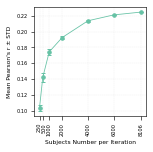

In [126]:
# Abundance
import matplotlib.transforms as transforms

def plot_robustness_abundance(robustness_means, robustness_stds, samples):
    plt.style.use(third_style)
    # Plot mean with standard deviations as error bars
    plt.figure()
    plt.errorbar(
        samples,
        robustness_means,
        yerr=robustness_stds,
        fmt='-o',
        capsize=2,
        label="Mean Pearson Correlations",
        # ecolor='black', 
        color=palette[0]
    )

    # Formatting
    # plt.title("Mean Pearson Correlations per Number of Subjects")
    plt.xlabel("Subjects Number per Iteration")
    plt.ylabel("Mean Pearson's r ± STD")
    # plt.xscale("log")  # Log scale for better visibility
    plt.xticks(samples, rotation=90)

    #--- In case of third style, space the ticks ---
    
    # Get the current axes and figure to apply a precise offset
    ax = plt.gca()
    fig = plt.gcf() # Get current figure, which is needed for the transform
    xticklabels = ax.get_xticklabels()

    # Create and apply a subtle offset to the first two labels
    # We pass 'fig=fig' to resolve the error
    # offset_left = transforms.offset_copy(xticklabels[0].get_transform(), fig=fig, x=-1.0, units='points')
    # xticklabels[0].set_transform(offset_left)
    # xticklabels[0].set_horizontalalignment('center')

    offset_right = transforms.offset_copy(xticklabels[1].get_transform(), fig=fig, x=1.0, units='points')
    xticklabels[1].set_transform(offset_right)
    xticklabels[1].set_horizontalalignment('center')



    plt.grid(alpha=0.5, linestyle='--')
    # plt.legend()

    # Show plot
    plt.savefig(home_path +f"figures/regression/{SPECIES}/abundance_robustness.png", dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
    plt.savefig(home_path +f"figures/regression/{SPECIES}/abundance_robustness.pdf", dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
    plt.show()


plot_robustness_abundance(robustness_means, robustness_stds, samples)

Diversity:

In [127]:
robustness_results, samples = read_robustness("div")
robustness_scores_richness, robustness_SEM_richness, robustness_scores_shannon, robustness_SEM_shannon , iterations, samples = robustness_calc(robustness_results, samples, "div")

print(robustness_scores_richness)
print(robustness_scores_shannon)
print(iterations)
print(samples)

[read_robustness] n=250 repeats=5
[read_robustness] n=500 repeats=5
[read_robustness] n=1000 repeats=5
[read_robustness] n=2000 repeats=5
[read_robustness] n=4000 repeats=5
[read_robustness] n=6000 repeats=5
[read_robustness] n=8106 repeats=5
[0.002787827762801464, 0.10687202692076432, 0.16787556758362862, 0.20312162079454446, 0.2335440234614706, 0.2349605080399071, 0.23589732204274344]
[0.01772188081230509, 0.1260820848484537, 0.16377146792469394, 0.1840433750538304, 0.2138573754985381, 0.21244631217975915, 0.21179521683839067]
[1, 2, 3, 4, 5, 6, 7]
[250, 500, 1000, 2000, 4000, 6000, 8106]


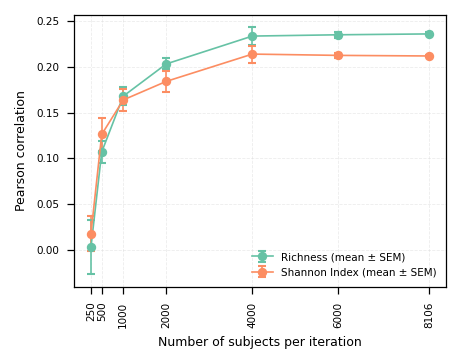

In [128]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms


# Assuming 'third_style', 'palette', 'home_path', and 'SPECIES' are defined
# and your data variables (robustness_scores_richness, etc.) are available.

def plot_robustness_div(rich_mean, rich_sem, shan_mean, shan_sem, samples, column="single"):
    plt.rcParams["figure.dpi"] = 150

    plt.style.use(single_style)

    plt.figure()

    # Mean ± SEM error bars
    plt.errorbar(
        samples, rich_mean, yerr=rich_sem,
        label="Richness (mean ± SEM)", markersize=3.5,
        marker='o', linestyle='-', linewidth=0.8, capsize=2, color=palette[0]
    )
    plt.errorbar(
        samples, shan_mean, yerr=shan_sem,
        label="Shannon Index (mean ± SEM)", markersize=3.5,
        marker='o', linestyle='-', linewidth=0.8, capsize=2, color=palette[1]
    )

    # Formatting
    plt.xlabel("Number of subjects per iteration")
    plt.ylabel("Pearson correlation")
    
    # Set the ticks and labels first
    plt.xticks(samples, rotation=90)
    
    # --- In case of third style, space the ticks ---
    
    # Get the current axes and figure to apply a precise offset
    # ax = plt.gca()
    # fig = plt.gcf() # Get current figure, which is needed for the transform
    # xticklabels = ax.get_xticklabels()

    # # Create and apply a subtle offset to the first two labels
    # # We pass 'fig=fig' to resolve the error
    # offset_left = transforms.offset_copy(xticklabels[0].get_transform(), fig=fig, x=-1.0, units='points')
    # xticklabels[0].set_transform(offset_left)
    # xticklabels[0].set_horizontalalignment('center')

    # offset_right = transforms.offset_copy(xticklabels[1].get_transform(), fig=fig, x=1.0, units='points')
    # xticklabels[1].set_transform(offset_right)
    # xticklabels[1].set_horizontalalignment('center')

    # --- MINIMAL CHANGES END ---
    
    plt.grid(alpha=0.5, linestyle='--')
    plt.legend()

    # standardize_panel(ax, inner_size=(2.2, 1.6))
    plt.savefig(home_path + f"figures/regression/{SPECIES}/diversity_robustness.png",
                dpi=400, facecolor="white", bbox_inches='tight')
    plt.savefig(home_path + f"figures/regression/{SPECIES}/diversity_robustness.pdf",
                dpi=400, facecolor="white", bbox_inches='tight')
    plt.show()


# Call
plot_robustness_div(
    robustness_scores_richness, robustness_SEM_richness,
    robustness_scores_shannon, robustness_SEM_shannon,
    samples, column="single"
)


### cFMD

In [129]:
cFMD_taxa = pd.read_csv(f"/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/tomerse/diet_mb/data/cFMD_taxa_only.tsv", sep='\t')
cFMD_meta = pd.read_csv(f"/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/tomerse/diet_mb/data/cFMD_metadata_only.tsv", sep='\t')
cFMD_taxa

,sample,YapM_2020__YapM_2020__ERR4142707,YapM_2020__YapM_2020__ERR4142708,YapM_2020__YapM_2020__ERR4142709,YapM_2020__YapM_2020__ERR4142710,YapM_2020__YapM_2020__ERR4142711,YapM_2020__YapM_2020__ERR4142712,YapM_2020__YapM_2020__ERR4142713,YapM_2020__YapM_2020__ERR4142714,YapM_2020__YapM_2020__ERR4142715,...,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2144_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2143_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2142_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2141_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2139_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2138_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2137_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2136_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2135_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2134_73322
0,s__Abiotrophia_defectiva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,s__Abiotrophia_sp_HMSC24B09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,s__Absicoccus_porci,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,s__Acetilactobacillus_jinshanensis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,s__Acetoanaerobium_noterae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3784,s__alpha_proteobacterium_L41A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3785,s__bacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3786,s__beta_proteobacterium_CB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3787,s__beta_proteobacterium_L13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
cFMD_taxa["sample"][cFMD_taxa["sample"].str.contains("lactis")].values

array(['s__Bifidobacterium_crudilactis', 's__Camelimonas_lactis',
       's__Chryseobacterium_lactis', 's__Epilithonimonas_lactis',
       's__Lactococcus_hircilactis', 's__Lactococcus_lactis',
       's__Lactococcus_raffinolactis', 's__Leuconostoc_lactis',
       's__Neomicrococcus_lactis', 's__Paenibacillus_lactis',
       's__Pseudomonas_paralactis', 's__Sphingobacterium_lactis'],
      dtype=object)

In [131]:
pd.Series(targets)[pd.Series(targets).str.contains("Lacto")]

Series([], dtype: object)

In [132]:
cFMD_meta

,sample,YapM_2020__YapM_2020__ERR4142707,YapM_2020__YapM_2020__ERR4142708,YapM_2020__YapM_2020__ERR4142709,YapM_2020__YapM_2020__ERR4142710,YapM_2020__YapM_2020__ERR4142711,YapM_2020__YapM_2020__ERR4142712,YapM_2020__YapM_2020__ERR4142713,YapM_2020__YapM_2020__ERR4142714,YapM_2020__YapM_2020__ERR4142715,...,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2144_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2143_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2142_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2141_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2139_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2138_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2137_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2136_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2135_73322,MASTER_WP4_CSIC_1__MASTER_WP4_CSIC_1__P2134_73322
0,macrocategory,food,food,food,food,food,food,food,food,food,...,food,food,food,food,food,food,food,food,food,food
1,category,dairy,dairy,dairy,dairy,dairy,dairy,dairy,dairy,dairy,...,dairy,dairy,dairy,dairy,dairy,dairy,dairy,dairy,dairy,dairy
2,type,raw_milk,raw_milk,raw_milk,raw_milk,raw_milk,raw_milk,raw_milk,raw_milk,raw_milk,...,cheese,cheese,whey,milk,cheese_brine,cheese_brine,cheese_brine,cheese_brine,cheese_brine,cheese_brine
3,subtype,bovine_milk,bovine_milk,bovine_milk,bovine_milk,bovine_milk,bovine_milk,bovine_milk,bovine_milk,bovine_milk,...,cheese_1_before_ripening;interior,cheese_1_before_ripening;rind,whey,raw_milk,brine,brine,brine,brine,brine,brine
4,country,IRL,IRL,IRL,IRL,IRL,IRL,IRL,IRL,IRL,...,ESP,ESP,ESP,ESP,ESP,ESP,ESP,ESP,ESP,ESP
5,source,public,public,public,public,public,public,public,public,public,...,master,master,master,master,master,master,master,master,master,master


In [133]:
pattern = '|'.join(significant_targets)
filtered_df = cFMD_taxa[cFMD_taxa['sample'].str.contains(pattern, regex=True, case=False)]
filtered_df = filtered_df.loc[:, ~(filtered_df == 0).all(axis=0)]
# filtered_df = filtered_df.set_index('sample')
filtered_df

""


In [134]:
for row in filtered_df["sample"]:
    print(row)


KeyError: 'sample'

In [ ]:

filtered_cFMD_meta = cFMD_meta[filtered_df.columns]
filtered_cFMD_meta.shape



(6, 1702)

In [ ]:
filtered_df.set_index("sample").to_csv(home_path + "/data/cFMD_taxa_filtered.tsv", sep="\t")
filtered_cFMD_meta.set_index("sample").to_csv(home_path + "/data/cFMD_metadata_filtered.tsv", sep="\t")

### Correlation of external health scores with phenotypes

In [ ]:
phenotypes_mb = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_mb.pkl')

with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/target_phenotypes.pkl', 'rb') as f:
    target_phenotypes = pickle.load(f)

phenotypes_mb = phenotypes_mb.set_index("RegistrationCode")#.drop_duplicates()
phenotypes_mb

,age,gender,vat_fat_ratio,android/gynoid ratio,fat_mass_index,waist_hips_ratio,waist_height_ratio,mean_hand_grip,ALM,ALMI,...,Alistipes avistercoris,Alistipes dispar,Tidjanibacter inops,Oxalobacter aliiformigenes,Oxalobacter formigenes,Duodenibacillus sp900544335,Aphodousia faecalis,Parasutterella gallistercoris,Parasutterella excrementihominis,Mesosutterella multiformis
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,54.0,1.0,0.056535,1.309820,7.462508,0.925234,0.548476,131.349998,30.758968,9.440986,...,-0.23671,1.022126,-0.555838,-0.803619,-0.308683,-0.246009,-0.242160,-0.267322,-0.784185,-0.414676
10K_1001201093,42.0,0.0,0.021434,0.734188,6.268973,0.783505,0.447059,67.349998,17.051393,5.900136,...,-0.23671,-0.708386,-0.555838,-0.803619,-0.308683,-0.246009,-0.242160,-0.267322,-0.784185,-0.414676
10K_1002254441,45.0,1.0,0.055767,1.174556,6.893385,0.947368,0.505618,86.250000,21.831000,6.890229,...,-0.23671,-0.708386,-0.555838,0.985879,-0.308683,-0.246009,-0.242160,-0.267322,1.701152,-0.414676
10K_1003113258,49.0,1.0,NaN,NaN,NaN,NaN,NaN,102.850002,NaN,NaN,...,-0.23671,0.024498,-0.555838,0.071970,-0.308683,-0.246009,-0.242160,-0.267322,-0.487051,-0.414676
10K_1007330152,63.0,1.0,NaN,1.595805,14.307040,1.035714,NaN,97.450001,25.144313,9.522107,...,-0.23671,-0.708386,1.739702,-0.803619,-0.308683,-0.246009,-0.242160,-0.267322,2.387421,1.520838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_6595065879,53.0,0.0,0.004003,0.641055,NaN,NaN,NaN,NaN,12.496091,NaN,...,-0.23671,-0.075460,-0.555838,-0.803619,-0.308683,-0.246009,-0.242160,-0.267322,-0.331236,-0.414676
10K_1439720299,51.0,1.0,0.041723,1.154418,NaN,NaN,NaN,NaN,22.371791,NaN,...,-0.23671,1.436553,0.713443,-0.803619,-0.308683,-0.246009,-0.242160,-0.267322,0.098614,-0.414676
10K_4637431621,57.0,0.0,0.037967,0.913265,NaN,NaN,NaN,NaN,15.591000,NaN,...,-0.23671,-0.708386,-0.555838,-0.803619,-0.308683,-0.246009,-0.242160,-0.267322,-0.784185,-0.414676


In [ ]:
target_phenotypes = [item for sublist in target_phenotypes for item in sublist]
phenotypes_mb[target_phenotypes].isnull().sum()

vat_fat_ratio                2978
android/gynoid ratio         2866
fat_mass_index               3081
waist_hips_ratio              116
waist_height_ratio            174
mean_hand_grip                 97
ALM                          2841
ALMI                         2901
ALM_BMI                      2889
sitting_systolic_bp_mean      186
sitting_diastolic_bp_mean     192
pulse_pressure                201
mean_arterial_pressure        182
total_scan_vat_mass          3132
liver_sound_speed_mps        2671
AHI                          4313
ODI                          4707
RDI                          4202
bt__urea                     7673
bt__wbc                      4199
bt__glucose                  7086
bt__mcv                      4166
bt__hemoglobin               4047
bt__uric_acid                8408
bt__total_cholesterol        7523
bt__triglycerides            7622
bt__non_hdl_cholesterol      7626
triglyceride_to_hdl_ratio    7724
bt__ldl_cholesterol          8623
bt__hdl_choles

In [ ]:
health_targets = ['modified_HACK_top17_score', 'GMWI2_score']
div_targets = ['Richness', 'Shannon_diversity']

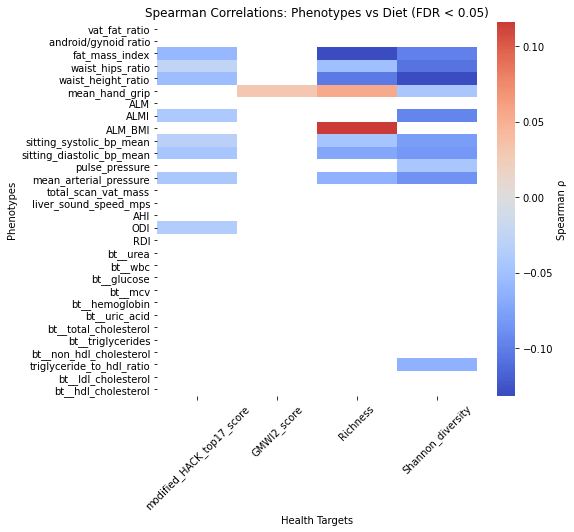

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# Initialize correlation and p-value matrices
corr_matrix = pd.DataFrame(index=health_targets + div_targets, columns=target_phenotypes, dtype=float)
pval_matrix = pd.DataFrame(index=health_targets + div_targets, columns=target_phenotypes, dtype=float)

min_valid_samples = 3

diet_mb = diet_mb.copy()
phenotypes_mb = phenotypes_mb.copy()
diet_mb.index = pd.Index(diet_mb.index, name="index")  # ensure named index
phenotypes_mb.index = pd.Index(phenotypes_mb.index, name="index")

# Compute correlations and p-values
for x_col in health_targets + div_targets:
    for y_col in target_phenotypes:
        valid = diet_mb[x_col].notna() & phenotypes_mb[y_col].notna()
        common_index = valid[valid].index  # filter to True values and extract index
        rho, pval = spearmanr(diet_mb.loc[common_index, x_col], phenotypes_mb.loc[common_index, y_col])
        if valid.sum() >= min_valid_samples:
            rho, pval = spearmanr(diet_mb.loc[valid, x_col], phenotypes_mb.loc[valid, y_col])
            corr_matrix.loc[x_col, y_col] = rho
            pval_matrix.loc[x_col, y_col] = pval

# Flatten and FDR-correct p-values
flat_pvals = pval_matrix.stack().dropna()
_, fdr_corrected_pvals, _, _ = multipletests(flat_pvals.values, method='fdr_bh')

# Initialize full FDR matrix
fdr_matrix = pd.DataFrame(np.nan, index=corr_matrix.index, columns=corr_matrix.columns)

# Assign corrected values properly using .loc
for (x, y), fdr_p in zip(flat_pvals.index, fdr_corrected_pvals):
    fdr_matrix.loc[x, y] = fdr_p


# Drop all-NaN rows/columns
filtered_corr = corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
filtered_fdr = fdr_matrix.loc[filtered_corr.index, filtered_corr.columns]

# Transpose for heatmap (phenotypes on Y-axis)
filtered_corr_T = filtered_corr.T
filtered_fdr_T = filtered_fdr.T

# Mask non-significant results (FDR ≥ 0.05)
mask = (filtered_fdr_T >= 0.05) | filtered_fdr_T.isna()

# Plot
if not filtered_corr_T.empty:
    plt.figure(figsize=(8, max(4, len(filtered_corr_T.index) * 0.25)))
    ax = sns.heatmap(filtered_corr_T.astype(float), mask=mask, annot=False,
                     cmap='coolwarm', center=0, fmt=".2f", cbar_kws={'label': "Spearman ρ"})
    ax.set_title("Spearman Correlations: Phenotypes vs Diet (FDR < 0.05)")
    ax.set_xlabel("Health Targets")
    ax.set_ylabel("Phenotypes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.savefig(home_path + "figures/regression/health_scores_vs_phenotypes_heatmap.svg", dpi=400, facecolor="white", transparent=False)
    plt.show()
else:
    print("No valid correlations found (all comparisons had too few overlapping non-NaN values).")


# Fruits VS Fiber

In [ ]:
import pandas as pd
import numpy as np

# path from your script
CSV = "/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/tomerse/diet_mb/results/fiber_fruits/reduced_feature_models_abundance_adjcov.csv"

df = pd.read_csv(CSV)

# Pivot to wide for quick comparisons
r2_wide = df.pivot_table(index="target", columns="model", values="r2")
r_wide  = df.pivot_table(index="target", columns="model", values="pearson_r")

# Attach deltas already in file
delta = df.pivot_table(index="target", columns="model", values="delta_r2_vs_fiber")

# Safety if some combos are missing
for col in ["fiber_only","fruit_only","fruit_fiber_inter"]:
    if col not in r2_wide.columns:
        r2_wide[col] = np.nan
    if col not in delta.columns:
        delta[col] = np.nan

# Labeling rules
thr_indep  = 0.02   # fruit vs fiber
thr_synerg = 0.02   # both+interaction vs best single
thr_small  = 0.01   # "little extra" margin

labels = []
for t, row in r2_wide.iterrows():
    r2_fiber = row["fiber_only"]
    r2_fruit = row["fruit_only"]
    r2_both  = row["fruit_fiber_inter"]

    d_fruit_vs_fiber = r2_fruit - r2_fiber
    best_single = np.nanmax([r2_fruit, r2_fiber])
    d_both_vs_best = r2_both - best_single

    if pd.isna(r2_fiber) or pd.isna(r2_fruit) or pd.isna(r2_both):
        label = "missing"
    elif (d_fruit_vs_fiber >= thr_indep) and (r2_both - r2_fruit < thr_small):
        label = "fruit_unique"
    elif d_both_vs_best >= thr_synerg:
        label = "synergy_or_mediation"
    elif (r2_fiber - r2_fruit) >= thr_indep:
        label = "fiber_dominated"
    else:
        label = "inconclusive"

    labels.append((t, d_fruit_vs_fiber, d_both_vs_best, label))

summary = pd.DataFrame(labels, columns=["target","delta_r2_fruit_vs_fiber","delta_r2_both_vs_best","label"])
summary = summary.merge(r2_wide.reset_index(), on="target", how="left")

# Save a tidy table to the same results dir
OUT = CSV.replace("reduced_feature_models_", "reduced_feature_models_summary_")
summary.to_csv(OUT, index=False)
print("Wrote:", OUT)

# Top examples to inspect
print("\nTop fruit_unique species:")
print(summary[summary.label=="fruit_unique"].sort_values("delta_r2_fruit_vs_fiber", ascending=False).head(10)[["target","delta_r2_fruit_vs_fiber","fruit_only","fiber_only","fruit_fiber_inter"]])

print("\nTop synergy_or_mediation species:")
print(summary[summary.label=="synergy_or_mediation"].sort_values("delta_r2_both_vs_best", ascending=False).head(10)[["target","delta_r2_both_vs_best","fruit_only","fiber_only","fruit_fiber_inter"]])


Wrote: /net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/tomerse/diet_mb/results/fiber_fruits/reduced_feature_models_summary_abundance_adjcov.csv

Top fruit_unique species:
Empty DataFrame
Columns: [target, delta_r2_fruit_vs_fiber, fruit_only, fiber_only, fruit_fiber_inter]
Index: []

Top synergy_or_mediation species:
Empty DataFrame
Columns: [target, delta_r2_both_vs_best, fruit_only, fiber_only, fruit_fiber_inter]
Index: []


In [ ]:
import pandas as pd
import numpy as np
import os

# Path to your results file
CSV = "/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/tomerse/diet_mb/results/fiber_fruits/reduced_feature_models_abundance_adjcov.csv"

# Load
df = pd.read_csv(CSV)

# 1) Coerce numerics just in case
for col in ["pearson_r","pearson_p","r2","delta_r2_vs_fiber","delta_r_vs_fiber","n_train","n_test"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 2) Quick sanity: how many targets have each model?
print("Counts by model:")
print(df["model"].value_counts(dropna=False))

print("\nRows per target:")
print(df.groupby("target")["model"].nunique().value_counts().sort_index())

# 3) Pivot to wide format for r2 and r
r2_wide = df.pivot_table(index="target", columns="model", values="r2")
r_wide  = df.pivot_table(index="target", columns="model", values="pearson_r")

# Ensure expected columns exist
for col in ["fiber_only","fruit_only","fruit_fiber_inter"]:
    if col not in r2_wide.columns:
        r2_wide[col] = np.nan
    if col not in r_wide.columns:
        r_wide[col] = np.nan

# 4) Labeling with tunable thresholds
thr_indep  = 0.02   # fruit vs fiber
thr_synerg = 0.02   # both vs best single
thr_small  = 0.01   # little extra improvement margin

labels = []
for t, row in r2_wide.iterrows():
    r2_fiber = row["fiber_only"]
    r2_fruit = row["fruit_only"]
    r2_both  = row["fruit_fiber_inter"]

    if pd.isna(r2_fiber) or pd.isna(r2_fruit) or pd.isna(r2_both):
        labels.append((t, np.nan, np.nan, "missing"))
        continue

    d_fruit_vs_fiber = r2_fruit - r2_fiber
    best_single = np.nanmax([r2_fruit, r2_fiber])
    d_both_vs_best = r2_both - best_single

    if (d_fruit_vs_fiber >= thr_indep) and (r2_both - r2_fruit < thr_small):
        lab = "fruit_unique"
    elif d_both_vs_best >= thr_synerg:
        lab = "synergy_or_mediation"
    elif (r2_fiber - r2_fruit) >= thr_indep:
        lab = "fiber_dominated"
    else:
        lab = "inconclusive"

    labels.append((t, d_fruit_vs_fiber, d_both_vs_best, lab))

summary = pd.DataFrame(labels, columns=["target","delta_r2_fruit_vs_fiber","delta_r2_both_vs_best","label"])
summary = summary.merge(r2_wide.reset_index(), on="target", how="left")

# 5) Overall counts to see what happened
print("\nLabel counts:")
print(summary["label"].value_counts(dropna=False))

# 6) If top tables were empty, still show best candidates by effect size
def show_top(df_in, cond_col, k=10):
    sub = df_in.dropna(subset=[cond_col]).sort_values(cond_col, ascending=False).head(k)
    return sub[["target","delta_r2_fruit_vs_fiber","delta_r2_both_vs_best","fiber_only","fruit_only","fruit_fiber_inter"]]

print("\nTop by delta_r2_fruit_vs_fiber (even if below threshold):")
print(show_top(summary, "delta_r2_fruit_vs_fiber", k=10))

print("\nTop by delta_r2_both_vs_best (even if below threshold):")
print(show_top(summary, "delta_r2_both_vs_best", k=10))

# 7) Save the summary next to your CSV
OUT = CSV.replace("reduced_feature_models_", "reduced_feature_models_summary_")
summary.to_csv(OUT, index=False)
print("\nWrote:", OUT)

# 8) Optional: try relaxed thresholds and re-label to see if anything pops
thr_indep_relaxed = 0.01
thr_synerg_relaxed = 0.01
thr_small_relaxed = 0.005

labels_relaxed = []
for t, row in r2_wide.iterrows():
    r2_fiber = row["fiber_only"]
    r2_fruit = row["fruit_only"]
    r2_both  = row["fruit_fiber_inter"]
    if pd.isna(r2_fiber) or pd.isna(r2_fruit) or pd.isna(r2_both):
        labels_relaxed.append((t, "missing"))
        continue
    d_fruit_vs_fiber = r2_fruit - r2_fiber
    best_single = np.nanmax([r2_fruit, r2_fiber])
    d_both_vs_best = r2_both - best_single
    if (d_fruit_vs_fiber >= thr_indep_relaxed) and (r2_both - r2_fruit < thr_small_relaxed):
        lab = "fruit_unique"
    elif d_both_vs_best >= thr_synerg_relaxed:
        lab = "synergy_or_mediation"
    elif (r2_fiber - r2_fruit) >= thr_indep_relaxed:
        lab = "fiber_dominated"
    else:
        lab = "inconclusive"
    labels_relaxed.append((t, lab))

relaxed = pd.DataFrame(labels_relaxed, columns=["target","label_relaxed"]).merge(summary[["target"]], on="target", how="right")
print("\nRelaxed label counts (0.01 thresholds):")
print(relaxed["label_relaxed"].value_counts(dropna=False))


Counts by model:
fiber_only           724
fruit_only           724
fruit_fiber_inter    724
Name: model, dtype: int64

Rows per target:
3    724
Name: model, dtype: int64

Label counts:
inconclusive       711
fiber_dominated     13
Name: label, dtype: int64

Top by delta_r2_fruit_vs_fiber (even if below threshold):
                              target  delta_r2_fruit_vs_fiber  \
110  fBin__262_gBin__1022_sBin__1551                 0.010548   
242  fBin__369_gBin__1480_sBin__2196                 0.010164   
258  fBin__371_gBin__1503_sBin__2233                 0.009449   
322  fBin__384_gBin__1580_sBin__2362                 0.008688   
255  fBin__371_gBin__1501_sBin__2230                 0.008438   
342  fBin__393_gBin__1619_sBin__2414                 0.008372   
226  fBin__367_gBin__1462_sBin__2172                 0.008296   
244  fBin__369_gBin__1490_sBin__2208                 0.008270   
99    fBin__257_gBin__989_sBin__1507                 0.007792   
76    fBin__249_gBin__918_sBin__1